In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path

import matplotlib.pyplot as plt

import utils

plt.style.use(
    [
        "tableau-colorblind10",
        utils.get_style("default"),
        utils.get_style("1-col-neurips"),
    ]
)
utils.import_plt_sty("robustness-macros.sty")

GAMES_DIR = Path("/shared/match/paper-robustness/cyclic-heatmap/games/")

In [2]:
"""Plots cycle shapes captured in adversarial Go games."""

import argparse
import itertools
import re
from typing import Iterable, Iterator, Optional, Tuple

import matplotlib
import numpy as np
from tqdm.notebook import tqdm

from go import Color, Game

BOARD_LEN = 19
# When this many stones or more are captured in one move, we check if it's a
# cyclic group.
CAPTURE_GROUP_SIZE_THRESHOLD = 20

# Substrings that appear uniquely in adversaries' and victims' names and are
# used to identify which player is the adversary.
ADVERSARY_NAME_SUBSTRINGS = ["adv", "attack"] + [f"r{i}-v600" for i in range(10)]
VICTIM_NAME_SUBSTRINGS = ["victim", "b18-"]


def get_sgf_property(property_name: str, sgf_string: str) -> str:
    """Returns the value of a property in an SGF string."""
    match = re.search(rf"{property_name}\[([^\]]+)\]", sgf_string)
    assert match is not None, f"No property {property_name} in SGF string {sgf_string}"
    return match.group(1)


def get_cycle_interior(cyclic_group: np.ndarray) -> np.ndarray:
    """Gets board points inside a cyclic group.
    Args:
        cyclic_group: Boolean map of cyclic group points.
    Returns:
        Boolean map of points inside the cyclic group.
    """
    ADJACENCIES = [[0, -1], [0, 1], [-1, 0], [1, 0]]
    visited = np.zeros_like(cyclic_group, dtype=bool)
    interior = ~cyclic_group
    x_max, y_max = cyclic_group.shape

    # Any point that has a path that reaches the edge of the board without
    # intersecting with the cyclic group is not interior. We DFS to find these
    # non-interior points.
    def dfs(x, y, previous_square=None):
        visited[x, y] = True
        # Checking interior[previous_square] handles the case where a previously
        # traversed square found a path to the edge of the board.
        if (
            (previous_square is not None and not interior[previous_square])
            or x == 0
            or y == 0
            or x == x_max - 1
            or y == y_max - 1
        ):
            interior[x, y] = False

        for x_inc, y_inc in ADJACENCIES:
            x_new = x + x_inc
            y_new = y + y_inc
            if (
                not (0 <= x_new < x_max)
                or not (0 <= y_new < y_max)
                or cyclic_group[x_new, y_new]
            ):
                continue
            if not visited[x_new, y_new]:
                dfs(x_new, y_new, previous_square=(x, y))
            # Checking interior[x_new, y_new] handles the case where a
            # subsequently traversed square finds a path to the edge of the board.
            if not interior[x_new, y_new]:
                interior[x, y] = False

    for x, y in np.ndindex(cyclic_group.shape):
        if not visited[x, y] and not cyclic_group[x, y]:
            dfs(x, y)

    return interior


def get_sgfs(paths: Iterable[Path]) -> Iterator[str]:
    """Yields all SGF games in the input files.
    Args:
        paths: List of paths where each path is an SGF file or a directory to
            recursively search for SGF files. Each SGF is assumed to be a single
            line.
    Yields:
        SGF strings.
    """
    for path in paths:
        if path.suffix in [".sgf", ".sgfs", ".txt"]:
            sgf_files = [path]
        else:
            sgf_files = itertools.chain(path.glob("**/*.sgf"), path.glob("**/*.sgfs"))

    for sgf_file in sgf_files:
        for sgf_string in open(sgf_file):
            yield sgf_string


def get_adversary_win_color(sgf_string: str) -> Optional[Color]:
    """Returns adversary color if the adversary wins, else returns None."""
    b_name = get_sgf_property("PB", sgf_string)
    w_name = get_sgf_property("PW", sgf_string)
    winner = get_sgf_property("RE", sgf_string)[0]
    adversary_is_w = False
    adversary_is_b = False
    for name in ADVERSARY_NAME_SUBSTRINGS:
        if name in b_name:
            adversary_is_b = True
        if name in w_name:
            adversary_is_w = True
    for name in VICTIM_NAME_SUBSTRINGS:
        if name in b_name:
            adversary_is_w = True
        if name in w_name:
            adversary_is_b = True
    assert (
        adversary_is_w != adversary_is_b
    ), f"Couldn't determine adversary: {b_name} vs. {w_name}"
    adversary_win = (adversary_is_b and winner == "B") or (
        adversary_is_w and winner == "W"
    )
    if not adversary_win:
        return None
    return Color.BLACK if adversary_is_b else Color.WHITE


def get_cyclic_capture(
    sgf_string: str,
    adversary_color: Color,
) -> Optional[Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]]:
    """Finds cyclic capture in a game and returns some board data about it.
    Args:
        sgf_string: The game to search for a cyclic capture.
        adversary_color: The color of the adversary.
    Returns:
        None if no cyclic capture is found, otherwise a tuple of the following
        board properties computed immediately after the capture:
            cyclic_group: Boolean map of cyclic group points.
            adversary_stones: Boolean map of adversary stones.
            victim_stones: Boolean map of victim stones.
            interior_adversary_stones: Boolean map of adversary stones inside
                the cyclic group.
            interior_victim_stones: Boolean map of victim stones inside the
                cyclic group.
    """
    victim_color = adversary_color.opponent()
    game = Game.from_sgf(sgf_string)

    # For each move, check for a capture by diffing the previous board with the
    # current board.
    #
    # The victim can suicide its cyclic group, so we need to check all moves,
    # not just the adversary's moves, for a capture.
    for i, (prev_board, board) in enumerate(
        zip(game.board_states, game.board_states[1:]),
    ):
        victim_stones = prev_board == victim_color.value
        empty_points = board == Color.EMPTY.value
        captured_stones = empty_points & victim_stones

        # When the adversary captures lots of victim stones and the victim
        # stones enclose at least one empty or adversary square, we guess that
        # it's capturing a cyclic group.
        if np.count_nonzero(captured_stones) < CAPTURE_GROUP_SIZE_THRESHOLD:
            continue
        interior = get_cycle_interior(captured_stones)
        interior_points = interior.nonzero()
        if len(interior_points[0]) == 0:
            continue

        # To get rid of some symmetries, flip cyclic group so that its center is
        # in the top-left corner, and flip across the diagonal if the center's
        # row coordinate is larger than the column coordinate.
        # (It's ambiguous which symmetry to use when the center lies upon an
        # axis of reflection. We don't attempt to handle this.)
        interior_centroid = np.average(interior.nonzero(), axis=1)
        for axis, coord in enumerate(interior_centroid):
            if coord > BOARD_LEN / 2:
                interior_centroid[axis] = BOARD_LEN - 1 - coord
                board = np.flip(board, axis)
                captured_stones = np.flip(captured_stones, axis)
                interior = np.flip(interior, axis)
        if interior_centroid[0] > interior_centroid[1]:
            interior_centroid[[0, 1]] = interior_centroid[[1, 0]]
            board = board.T
            captured_stones = captured_stones.T
            interior = interior.T

        adversary_stones = board == adversary_color.value
        victim_stones = board == victim_color.value
        interior_adversary_stones = interior & adversary_stones
        interior_victim_stones = interior & victim_stones

        return (
            captured_stones,
            adversary_stones,
            victim_stones,
            interior_adversary_stones,
            interior_victim_stones,
        )
    return None


def get_heat_maps(paths: Iterable[Path], debug: bool = False) -> Tuple[int, np.ndarray]:
    """Computes heat maps about cyclic capture data from games.
    Args:
        paths: List of paths where each path is an SGF file or a directory to
            recursively search for SGF files.
        debug: If true, break after finding two games. This is faster testing, as 
            processing many games takes a long time.
    Returns:
        num_cycles: Number of cyclic captures used to compute the heat maps.
        heat_maps: shape [5, BOARD_LEN, BOARD_LEN], stacking 5 heat maps:
            cycle_heat_map: Heat map of cyclic group points.
            adversary_heat_map: Heat map of adversary stones.
            victim_heat_map: Heat map of victim stones.
            interior_adversary_heat_map: Heat map of adversary stones inside
                the cyclic group.
            interior_victim_heat_map: Heat map of victim stones inside the
                cyclic group.
    """
    num_cycles = 0
    cycle_heat_map = np.zeros((BOARD_LEN, BOARD_LEN))
    adversary_heat_map = np.zeros((BOARD_LEN, BOARD_LEN))
    victim_heat_map = np.zeros((BOARD_LEN, BOARD_LEN))
    interior_adversary_heat_map = np.zeros((BOARD_LEN, BOARD_LEN))
    interior_victim_heat_map = np.zeros((BOARD_LEN, BOARD_LEN))
    for sgf_string in tqdm(list(get_sgfs(paths))):
        if int(get_sgf_property("SZ", sgf_string)) != BOARD_LEN:
            continue
        adversary_color = get_adversary_win_color(sgf_string)
        if adversary_color is None:
            # Skip games that the adversary loses.
            continue
        capture_data = get_cyclic_capture(sgf_string, adversary_color)
        if capture_data is None:
            # It's not necessarily a problem if we do not detect a cyclic
            # capture. The victim may have resigned, or in match and victimplay,
            # the game can end due to BoardHistory::endGameIfAllPassAlive().
            continue

        num_cycles += 1
        cycle_heat_map += capture_data[0]
        adversary_heat_map += capture_data[1]
        victim_heat_map += capture_data[2]
        interior_adversary_heat_map += capture_data[3]
        interior_victim_heat_map += capture_data[4]

        if debug and num_cycles >= 2:
            break

    heat_maps = np.stack(
        (
            cycle_heat_map,
            adversary_heat_map,
            victim_heat_map,
            interior_adversary_heat_map,
            interior_victim_heat_map,
        ),
    )
    heat_maps /= num_cycles
    return num_cycles, heat_maps


def plot_heat_maps(
    heat_maps: np.ndarray,
    is_diff: bool,
    plot_title: str,
    output_path: Optional[Path],
) -> None:
    """Plots heat maps about cyclic capture data.
    Args:
        heat_maps: Heat maps from get_heat_maps().
        is_diff: If True, the heat maps are a diff and have a range of [-1, 1].
            Otherwise they have a range of [0, 1].
        plot_title: Title of the whole plot.
        output_path: If None the plot will be shown and not saved, otherwise
            the plot is saved to this path.
    """
    cycle_heat_map = heat_maps[0]
    adversary_heat_map = heat_maps[1]
    victim_heat_map = heat_maps[2]
    interior_adversary_heat_map = heat_maps[3]
    interior_victim_heat_map = heat_maps[4]

    fig, axs = plt.subplots(3, 2, figsize=(plt.rcParams["figure.figsize"][0], 7), sharey=True)

    if is_diff:
        color_map = matplotlib.colormaps.get_cmap("RdBu")
        vmin = -1
    else:
        color_map = matplotlib.colormaps.get_cmap("Blues")
        vmin = 0
    normalizer = matplotlib.colors.Normalize(vmin=vmin, vmax=1)

    def plot_data(figure_row, figure_column, data, title):
        ax = axs[figure_row, figure_column]
        ax.imshow(data, cmap=color_map, norm=normalizer)
        ax.title.set_text(title)

    plot_data(0, 0, cycle_heat_map, "Cyclic group")
    axs[0, 1].axis("off")  # Unused plot space
    plot_data(1, 0, adversary_heat_map, "Adversary stones")
    plot_data(1, 1, interior_adversary_heat_map, "Interior adversary stones")
    plot_data(2, 0, victim_heat_map, "Victim stones")
    plot_data(2, 1, interior_victim_heat_map, "Interior victim stones")
    for _, ax in np.ndenumerate(axs):
        ax.set_xticks(range(0, BOARD_LEN, 5))
        ax.set_yticks(range(0, BOARD_LEN, 5))
        ax.set_xticks(range(BOARD_LEN), minor=True)
        ax.set_yticks(range(BOARD_LEN), minor=True)
        ax.xaxis.set_ticks_position("both")
        ax.yaxis.set_ticks_position("both")
    fig.suptitle(plot_title)
    fig.tight_layout()

    color_bar_info = matplotlib.cm.ScalarMappable(cmap=color_map, norm=normalizer)
    fig.colorbar(color_bar_info, ax=axs)

    if output_path is None:
        plt.show()
    else:
        fig.savefig(output_path)


def main(
    files: list[Path],
    title: str,
    output_path: str,
    diff_files: list[Path] = [],
):
    """Script entrypoint.

    Args
    ----
    files: Input directories to be searched recursively for SGFs, or SGF files/
    title: Title of the plot.
    output_path: Output file of the plot.
    diff_files: Files to compare with the input files. If specified, the heat
        maps will be a diff of [heat maps for files] minus [heat maps for diff_files].
    """
    num_samples, heat_maps = get_heat_maps(files)

    is_diff = len(diff_files) > 0
    if is_diff:
        _, other_heat_maps = get_heat_maps(diff_files)
        heat_maps -= other_heat_maps

    plot_heat_maps(
        heat_maps=heat_maps,
        is_diff=is_diff,
        plot_title=title,
        output_path=output_path,
    )

  0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_429389/785394425.py:319: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


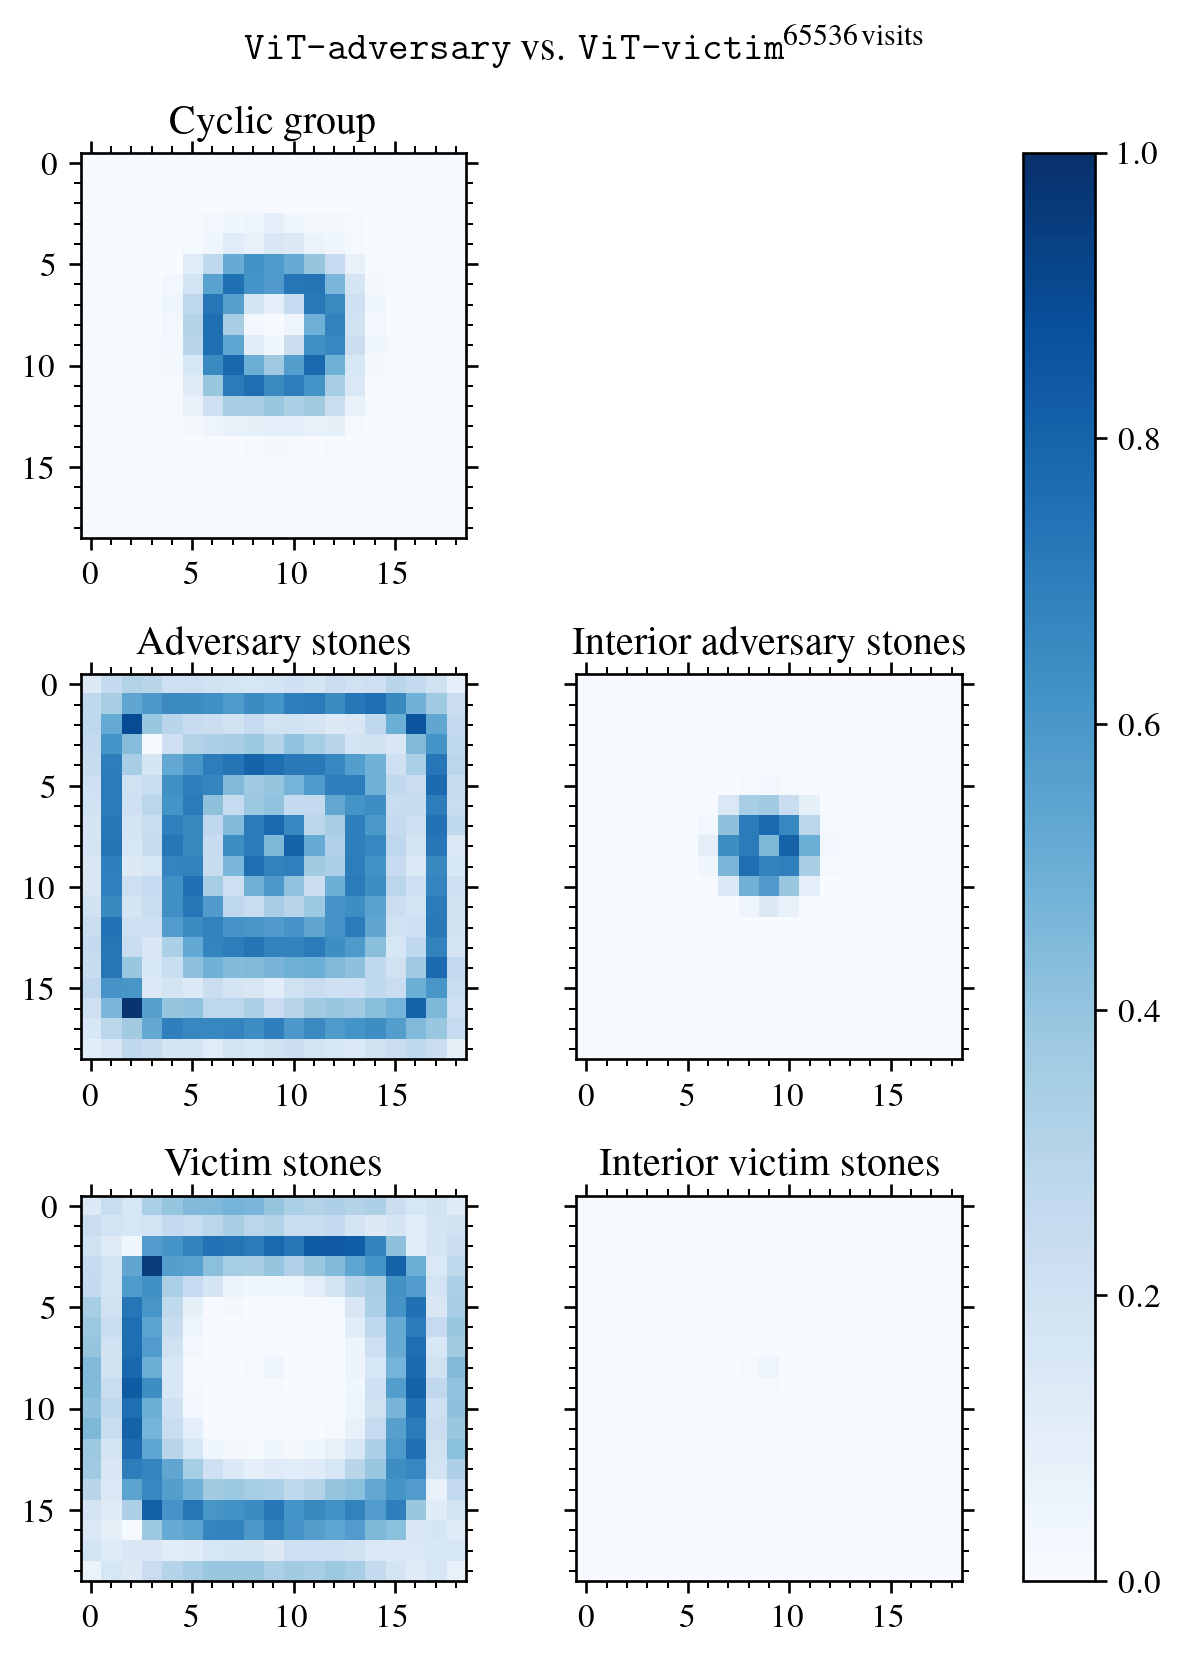

In [3]:
main(
    files=[GAMES_DIR / "attack-vit.sgfs"],
    title=r"\vitadversary{} vs. $\vitvictim{}^\mathrm{65536\,visits}$",
    output_path="cyclic-heatmap-attack-vit.pgf",
)

  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_429389/785394425.py:319: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


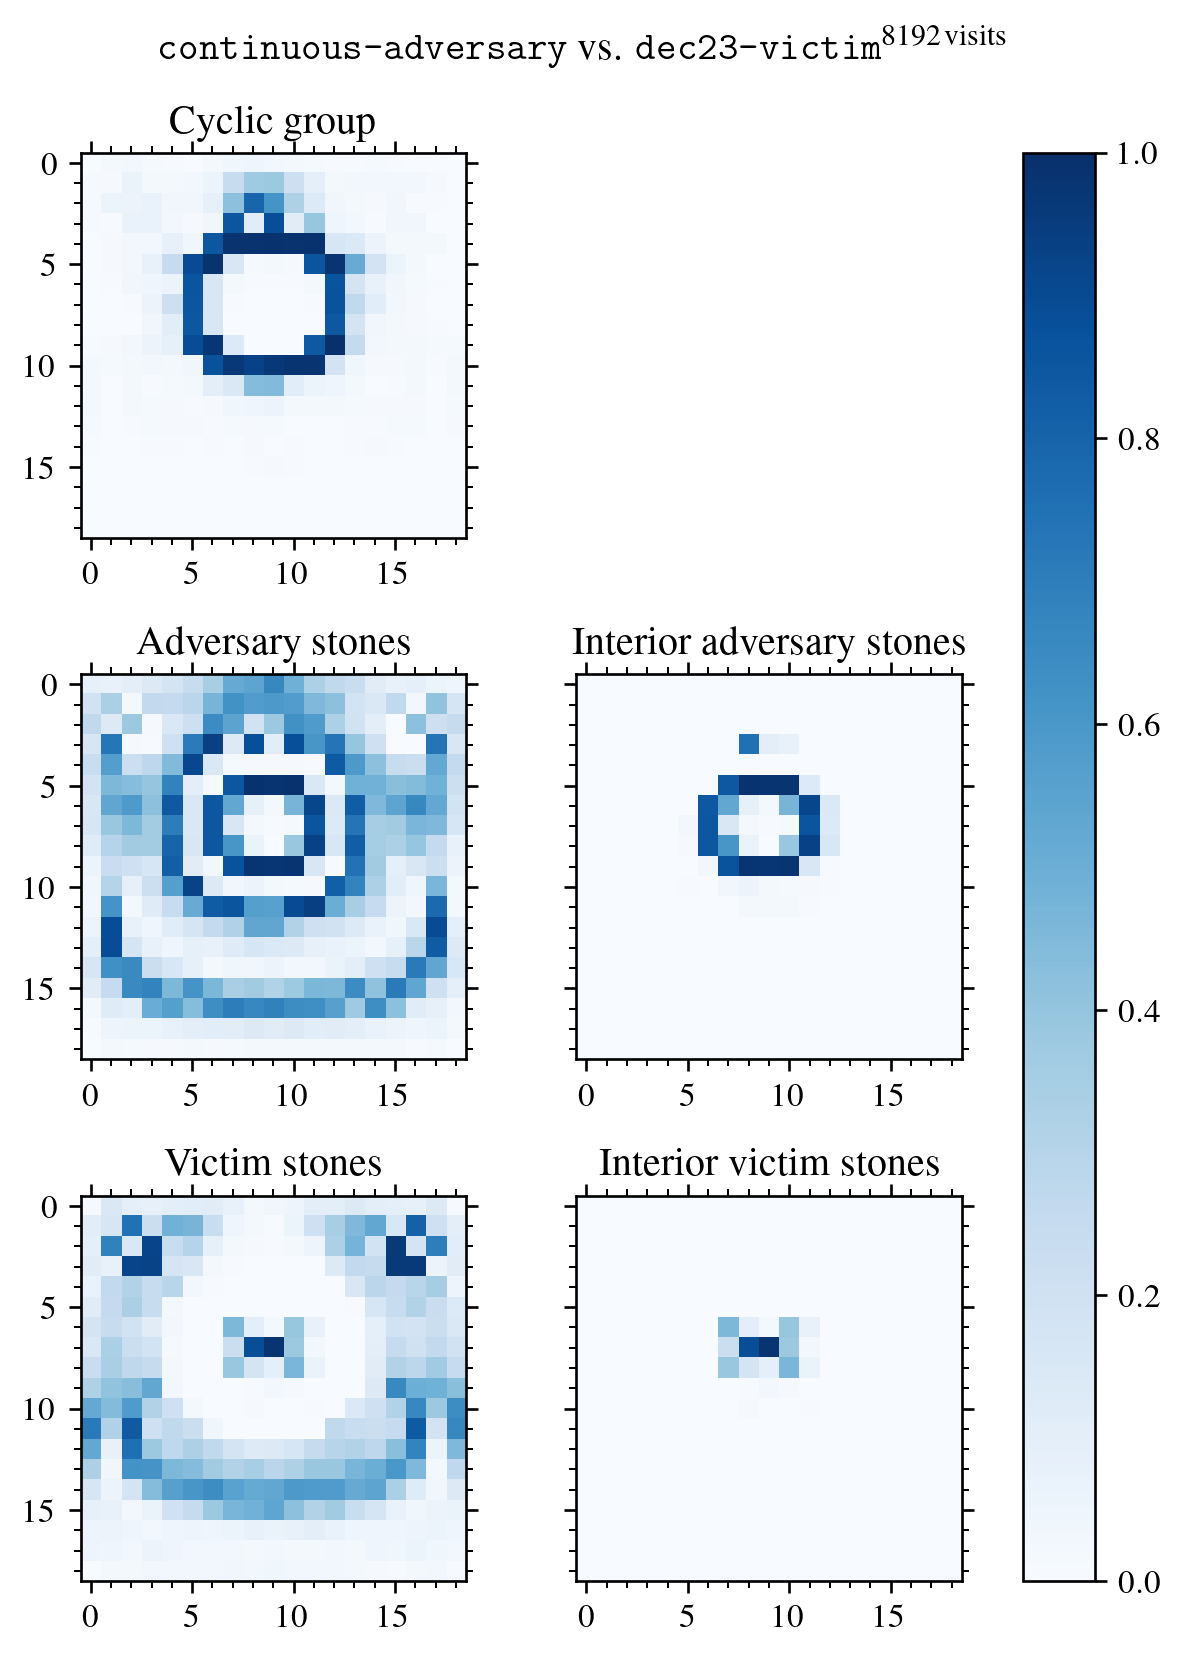

In [4]:
main(
    files=[GAMES_DIR / "continuous-adversary.sgfs"],
    title=r"\contadv{} vs. $\dectwentythree{}^\mathrm{8192\,visits}$",
    output_path="cyclic-heatmap-continuous-adversary.pgf",
)

  0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_429389/785394425.py:319: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


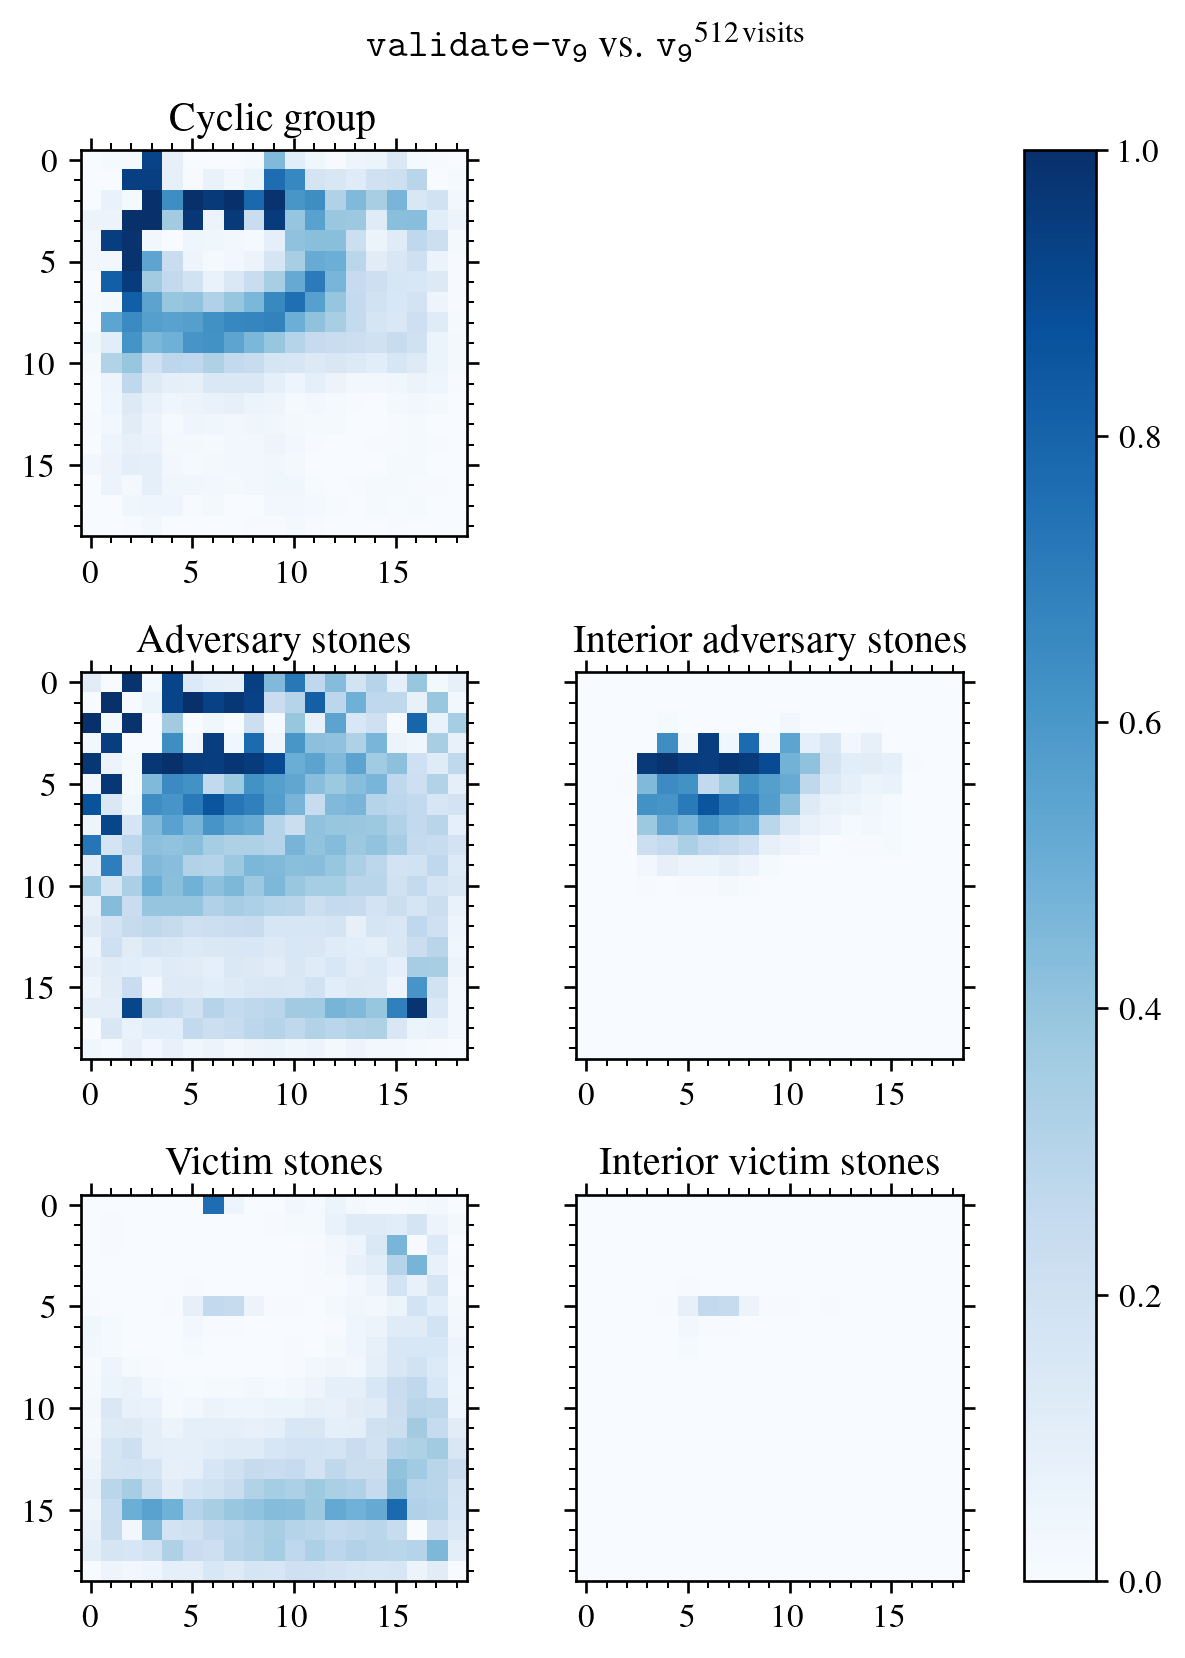

In [5]:
main(
    files=[GAMES_DIR / "attack-h9.sgfs"],
    title=r"\attackhnine{} vs. $\defenseiter{9}^\mathrm{512\,visits}$",
    output_path="cyclic-heatmap-attack-h9.pgf",
)

  0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_429389/785394425.py:319: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

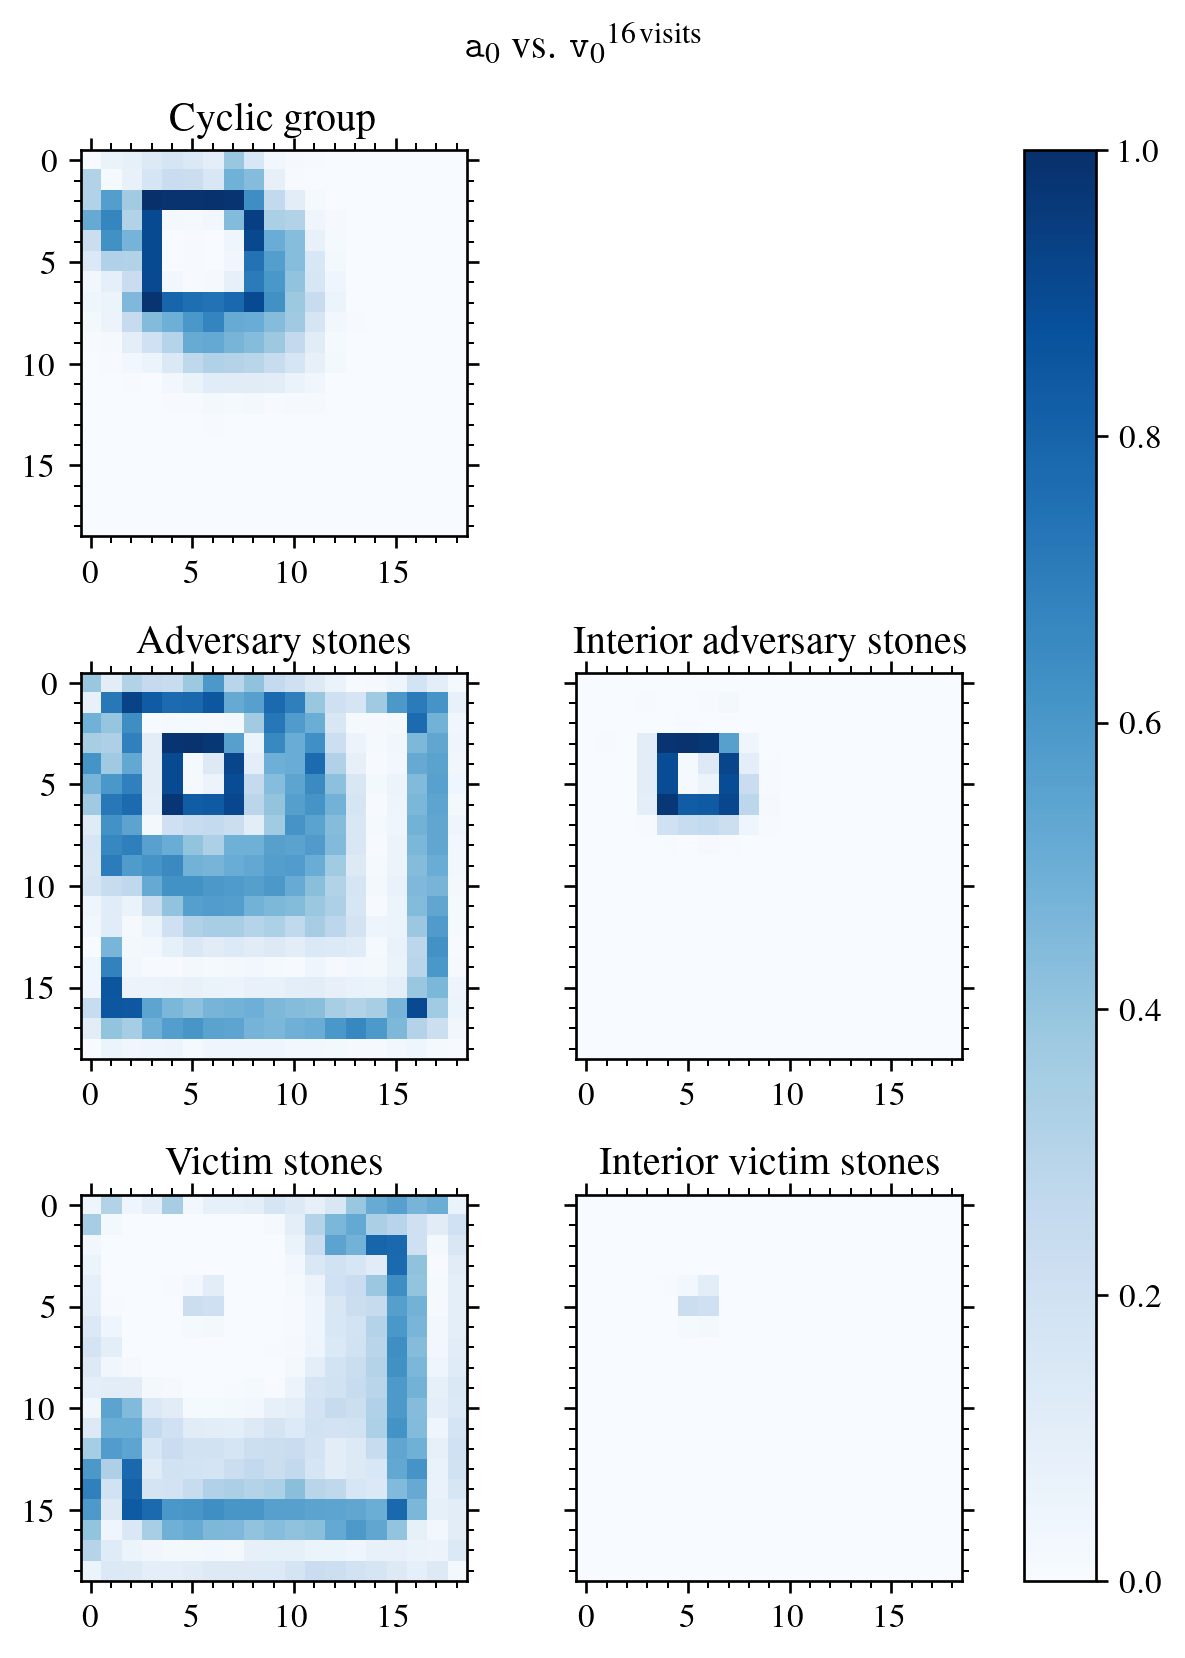

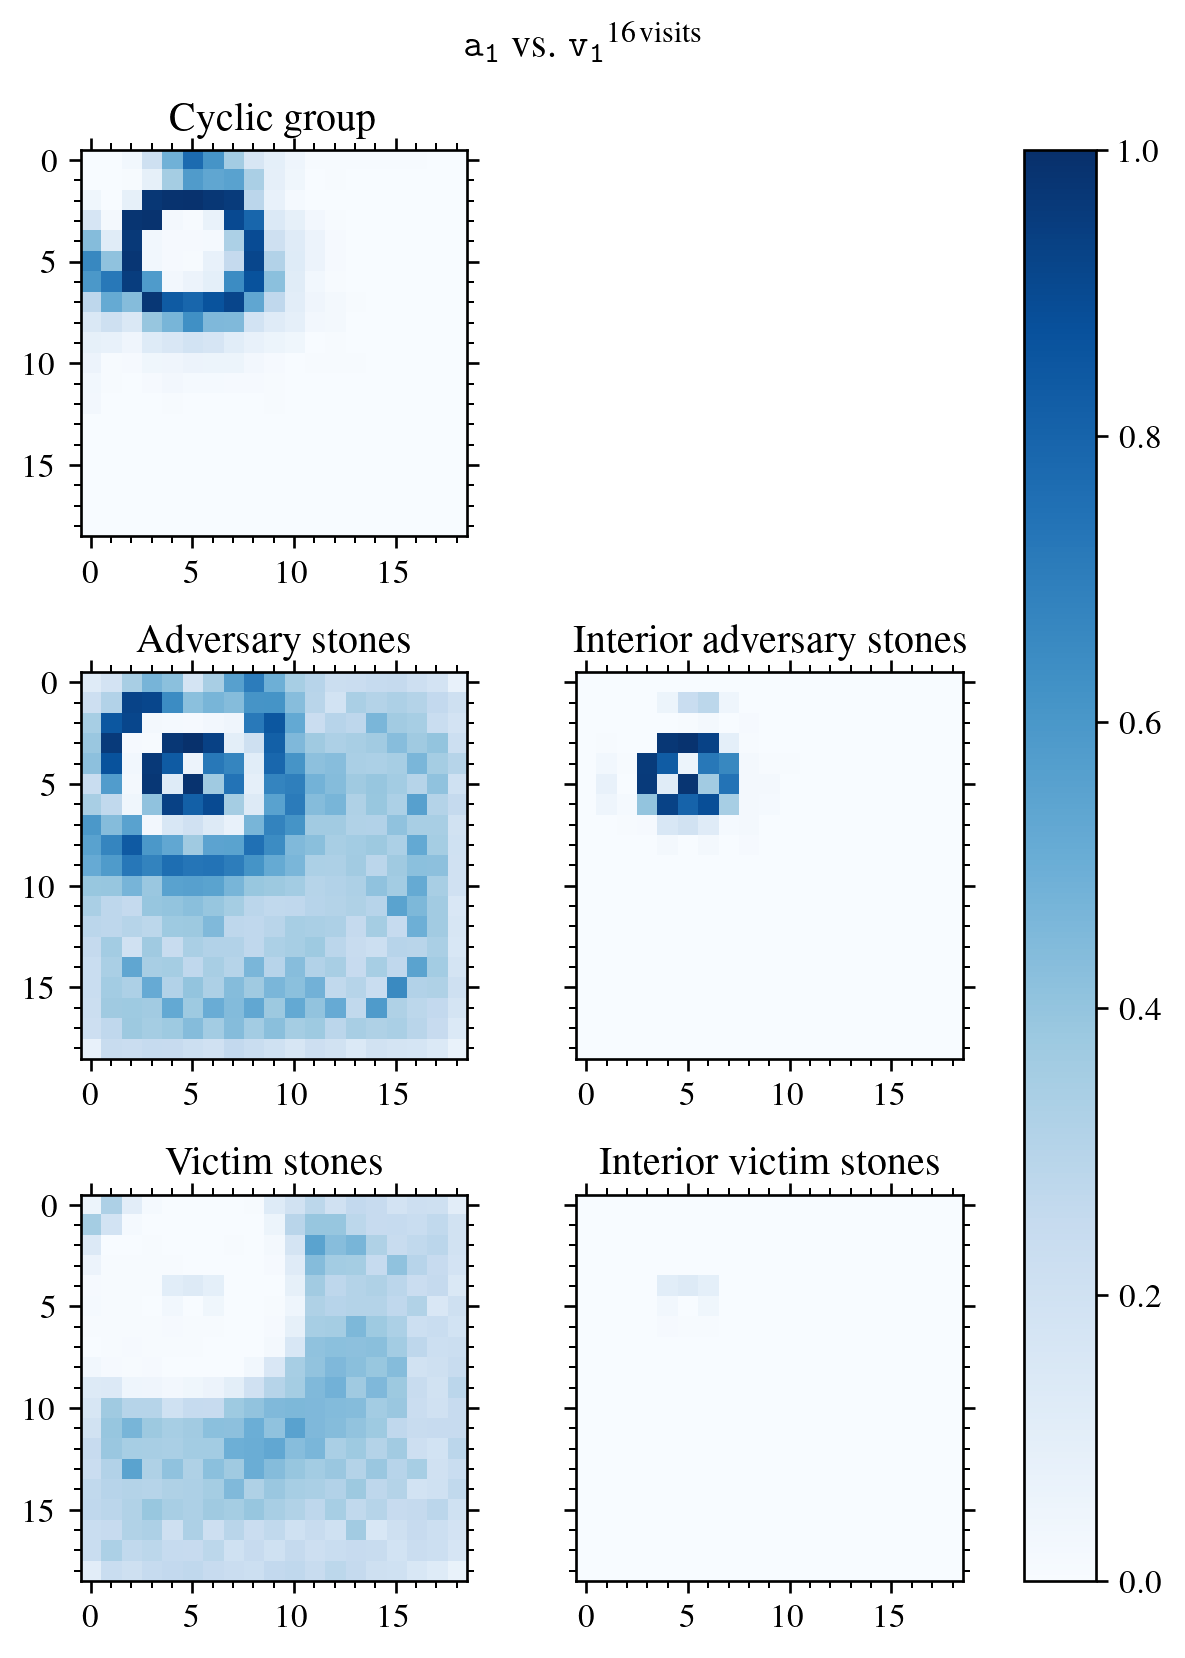

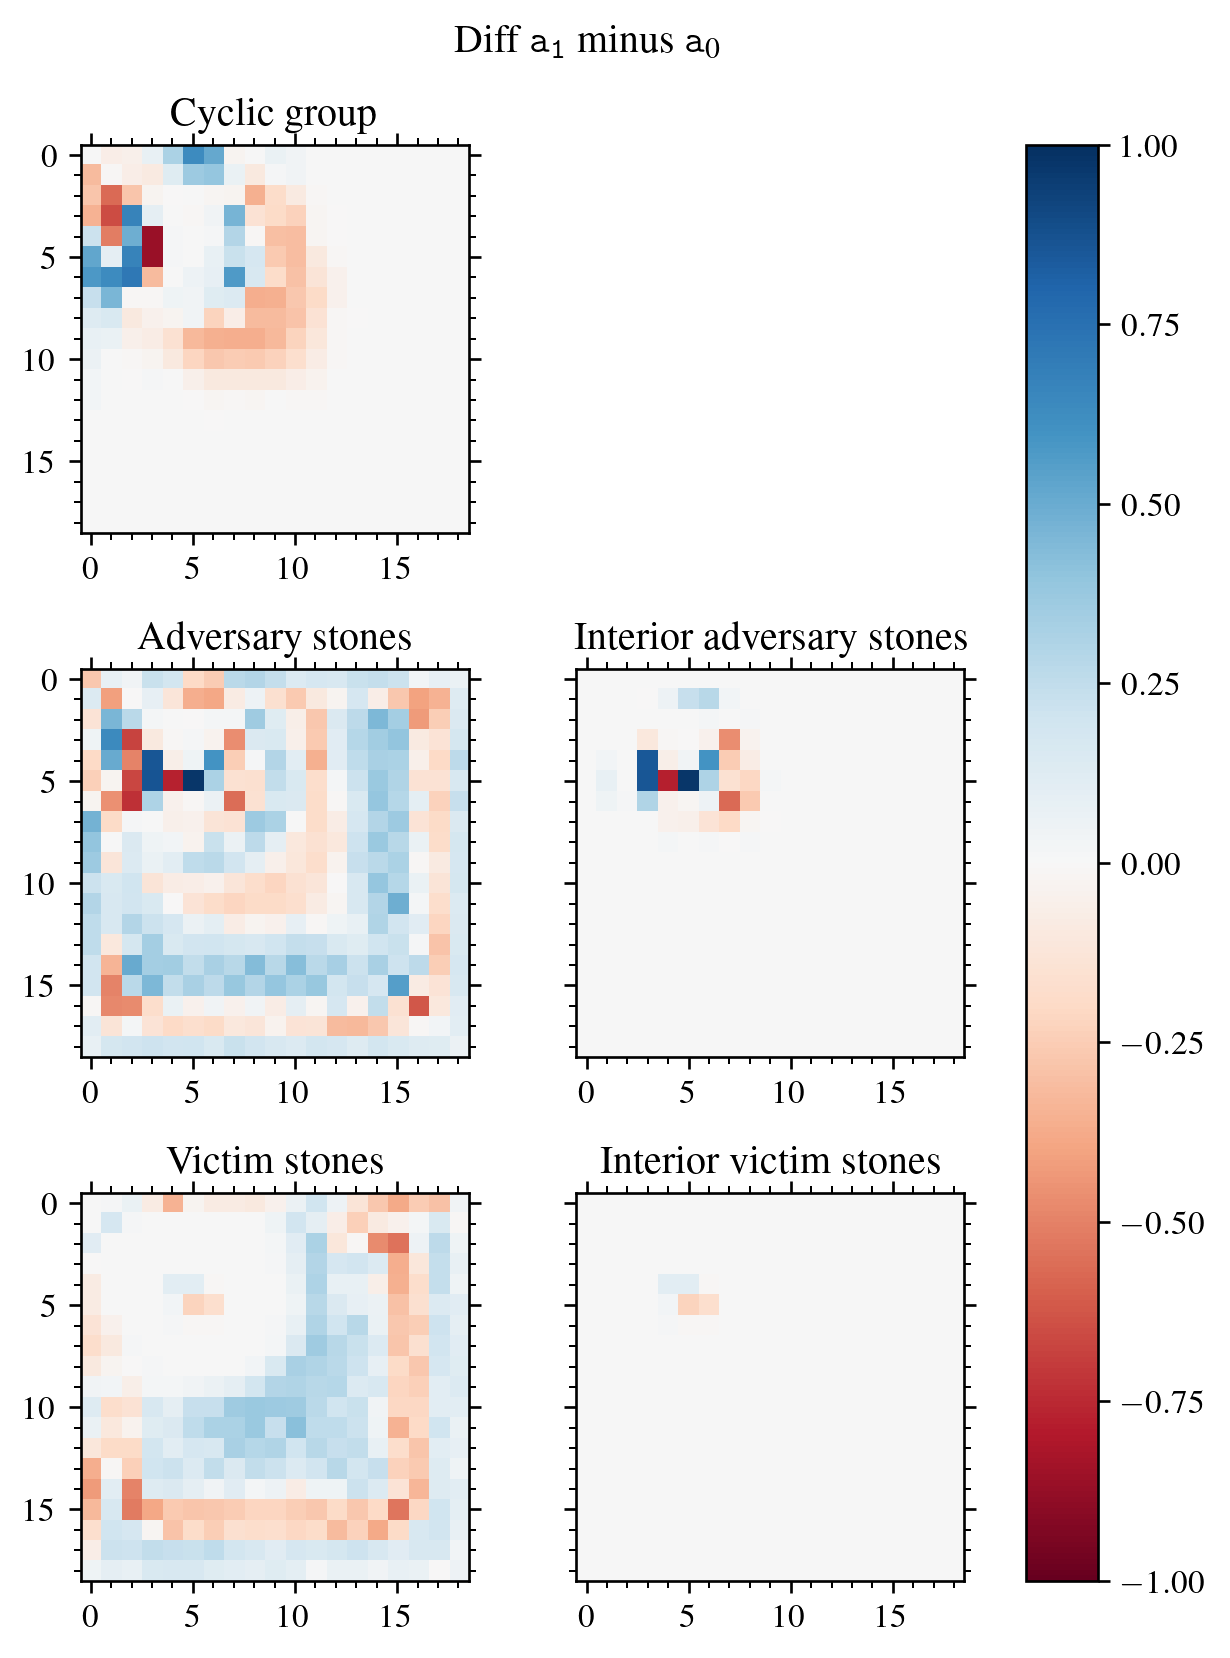

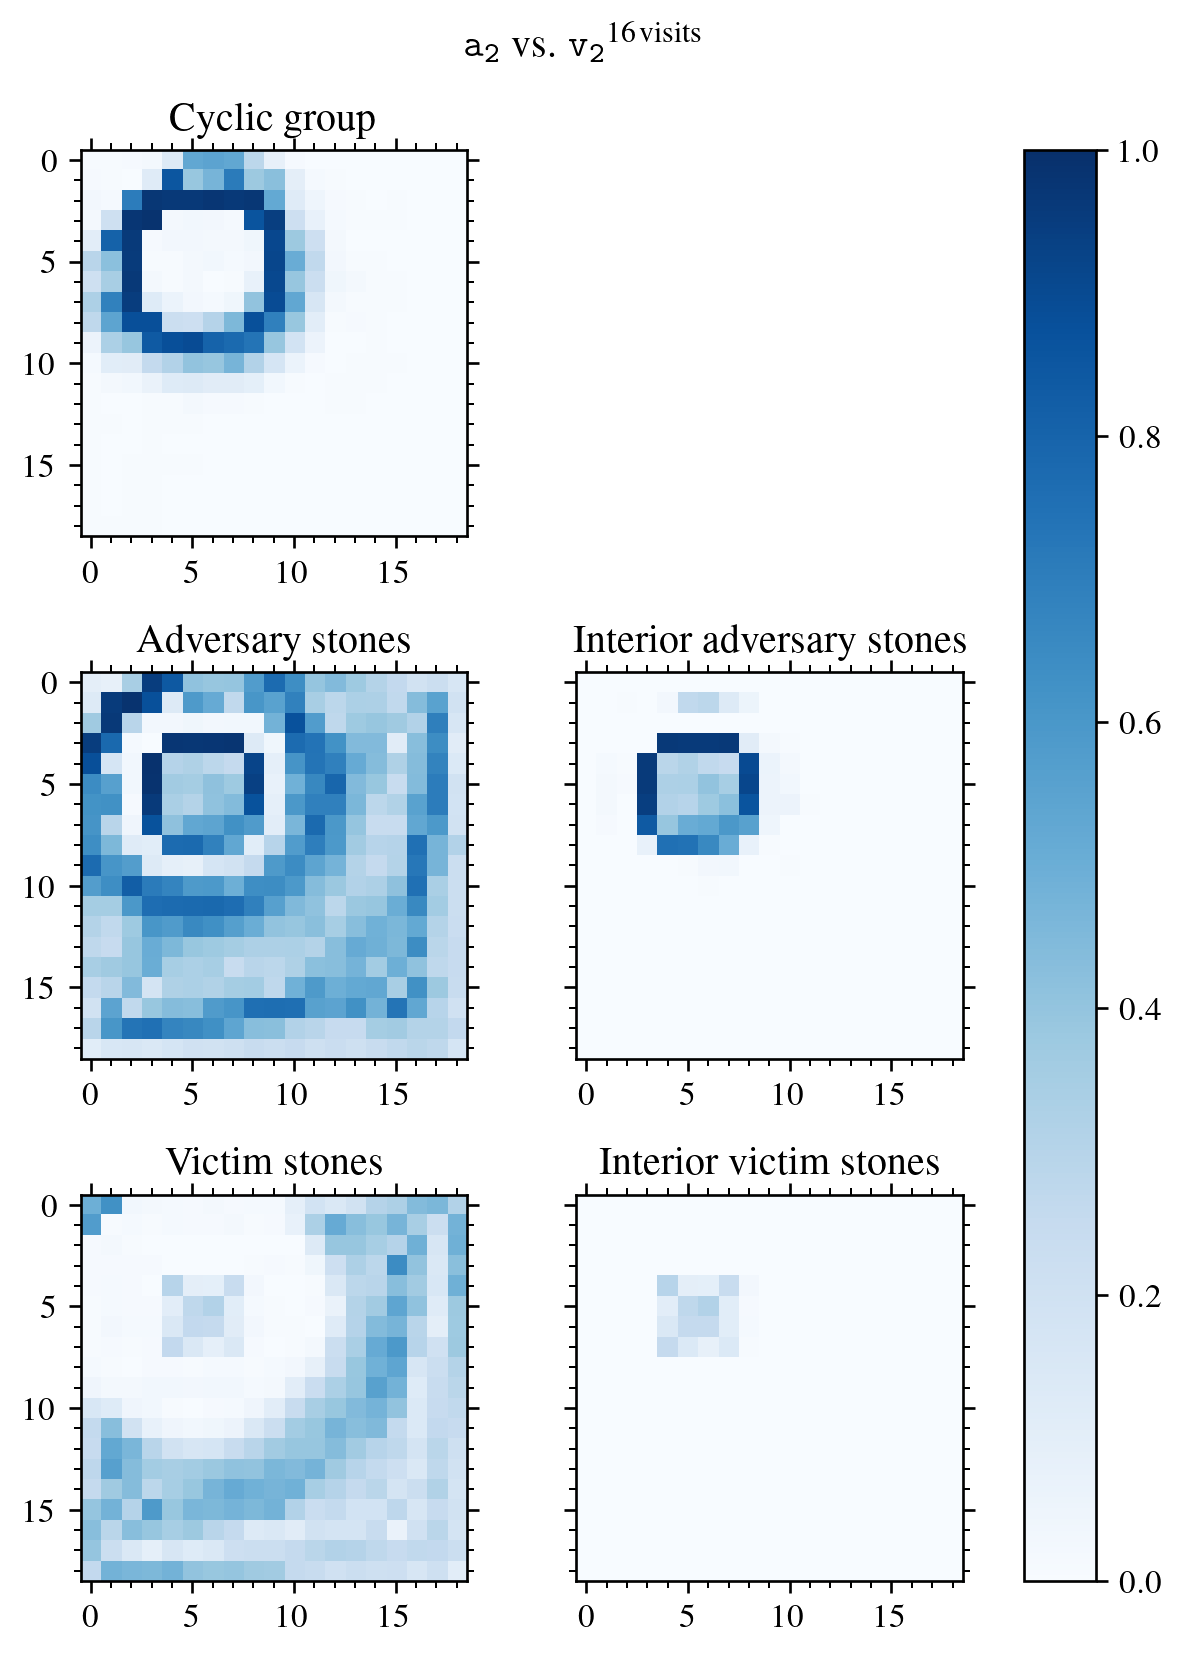

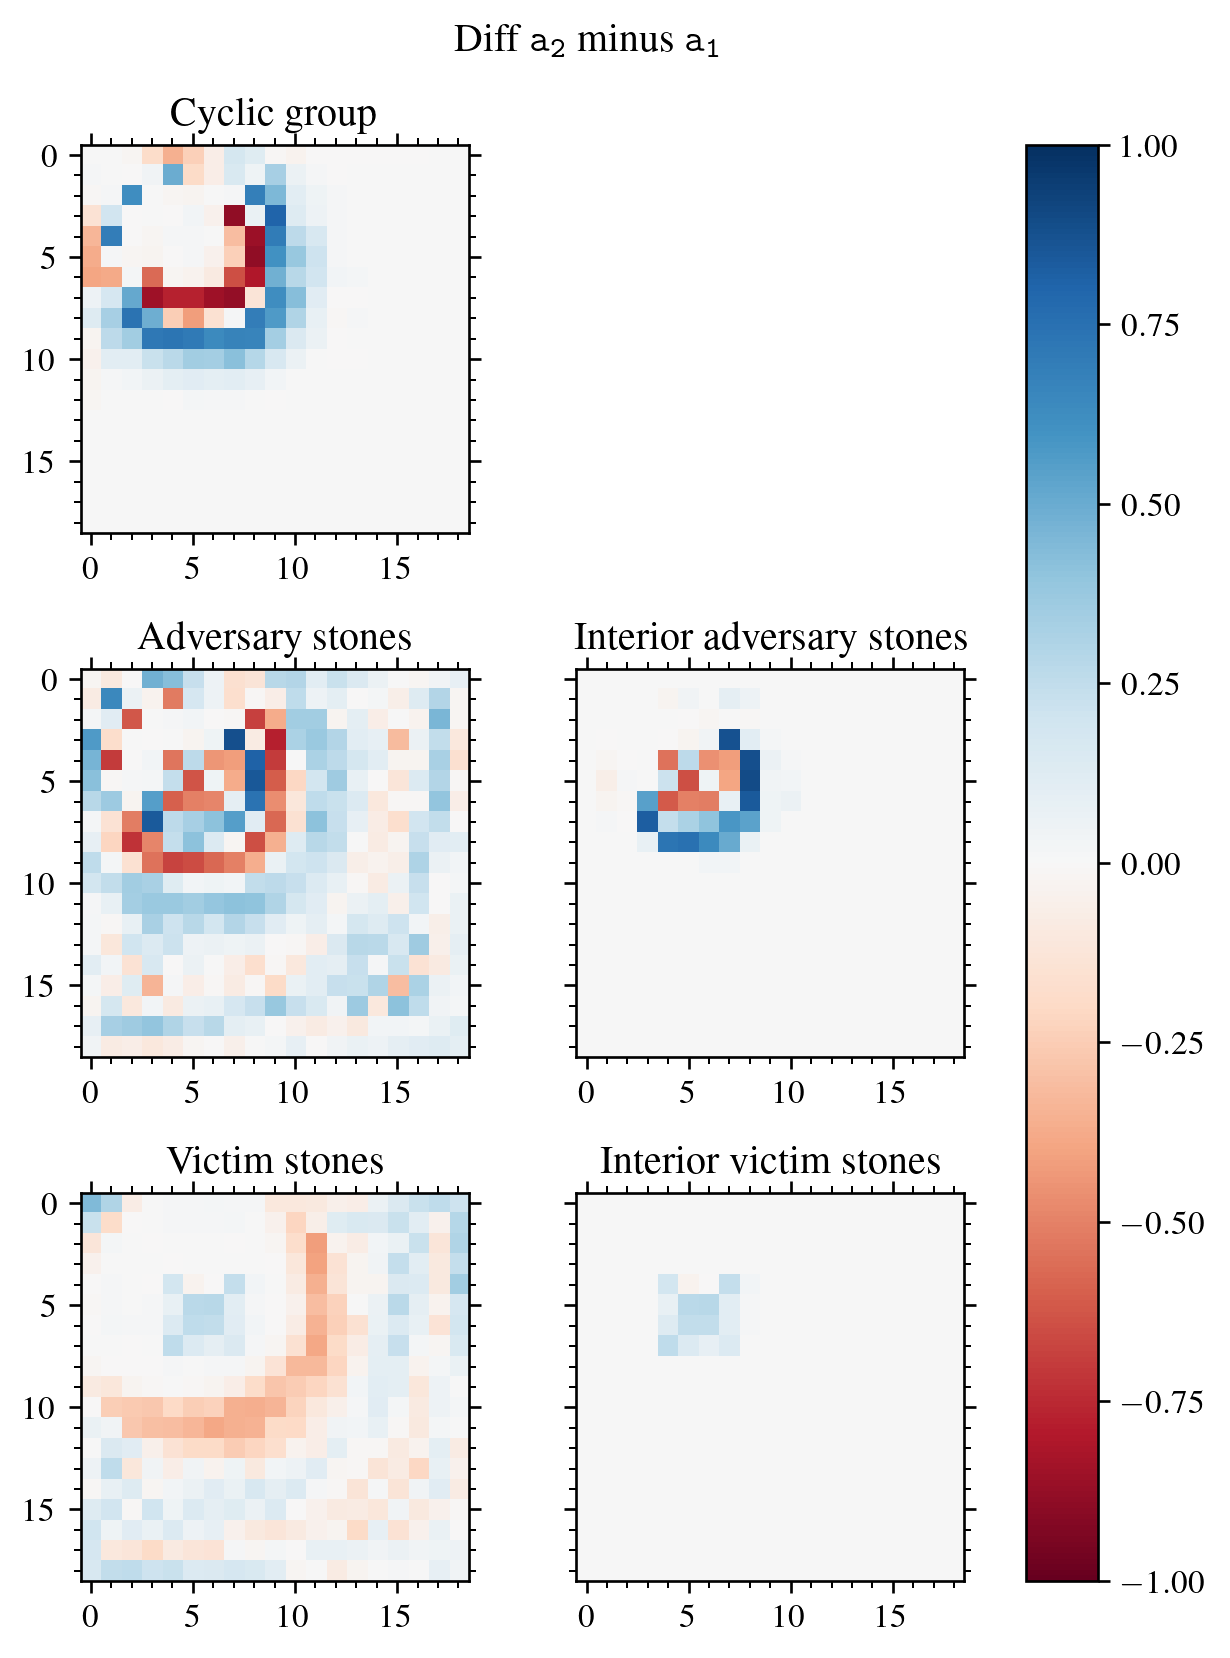

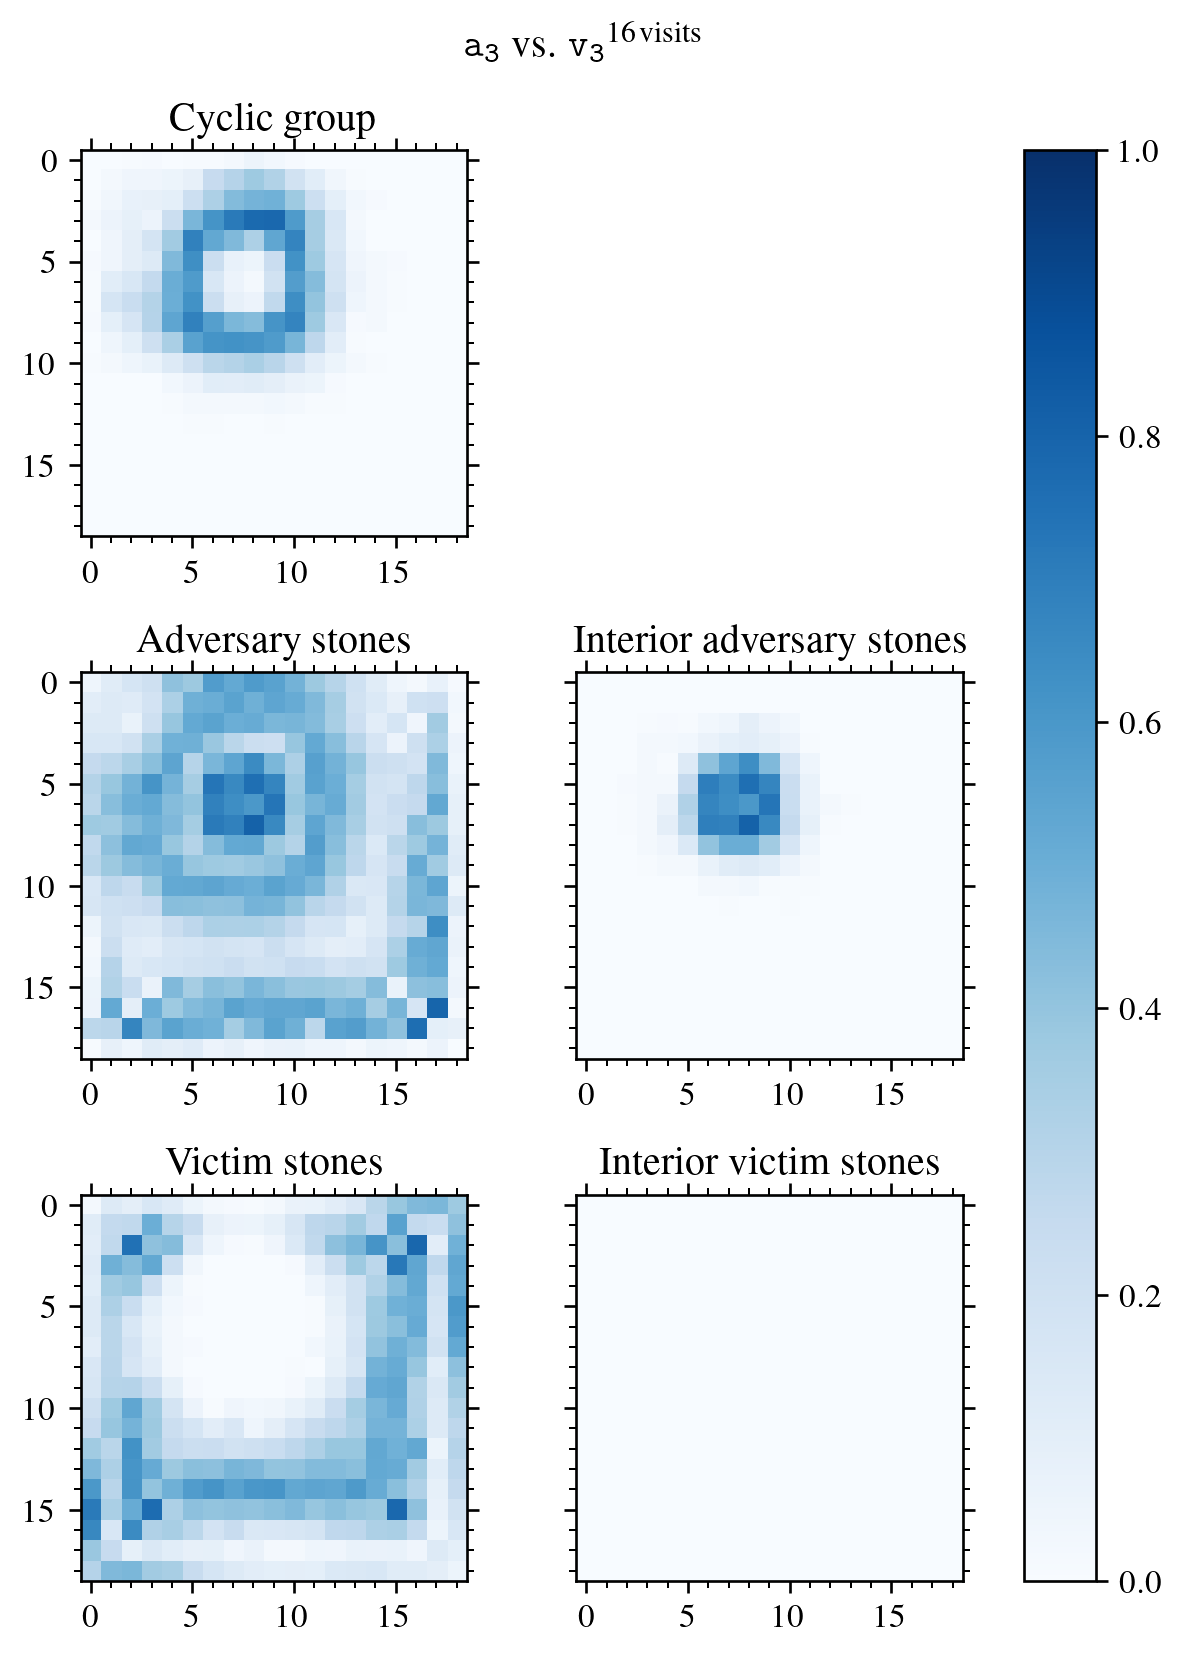

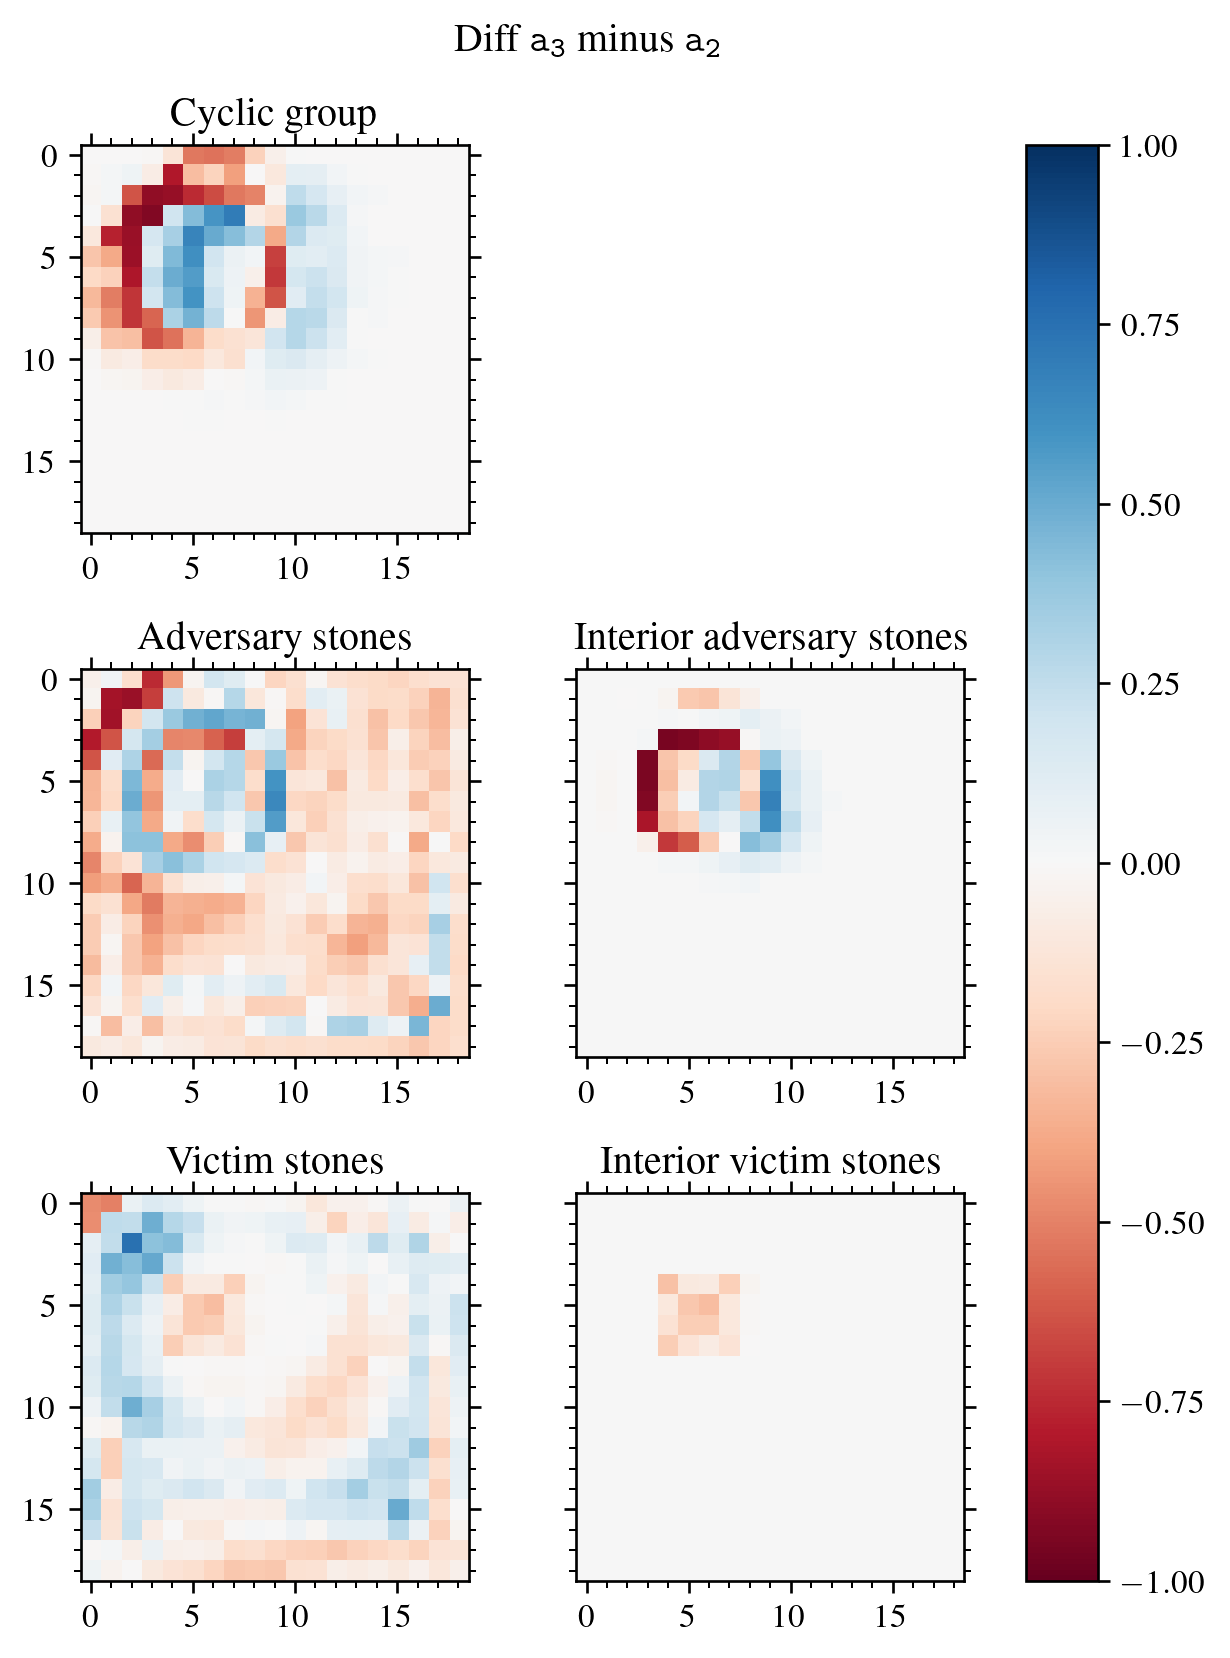

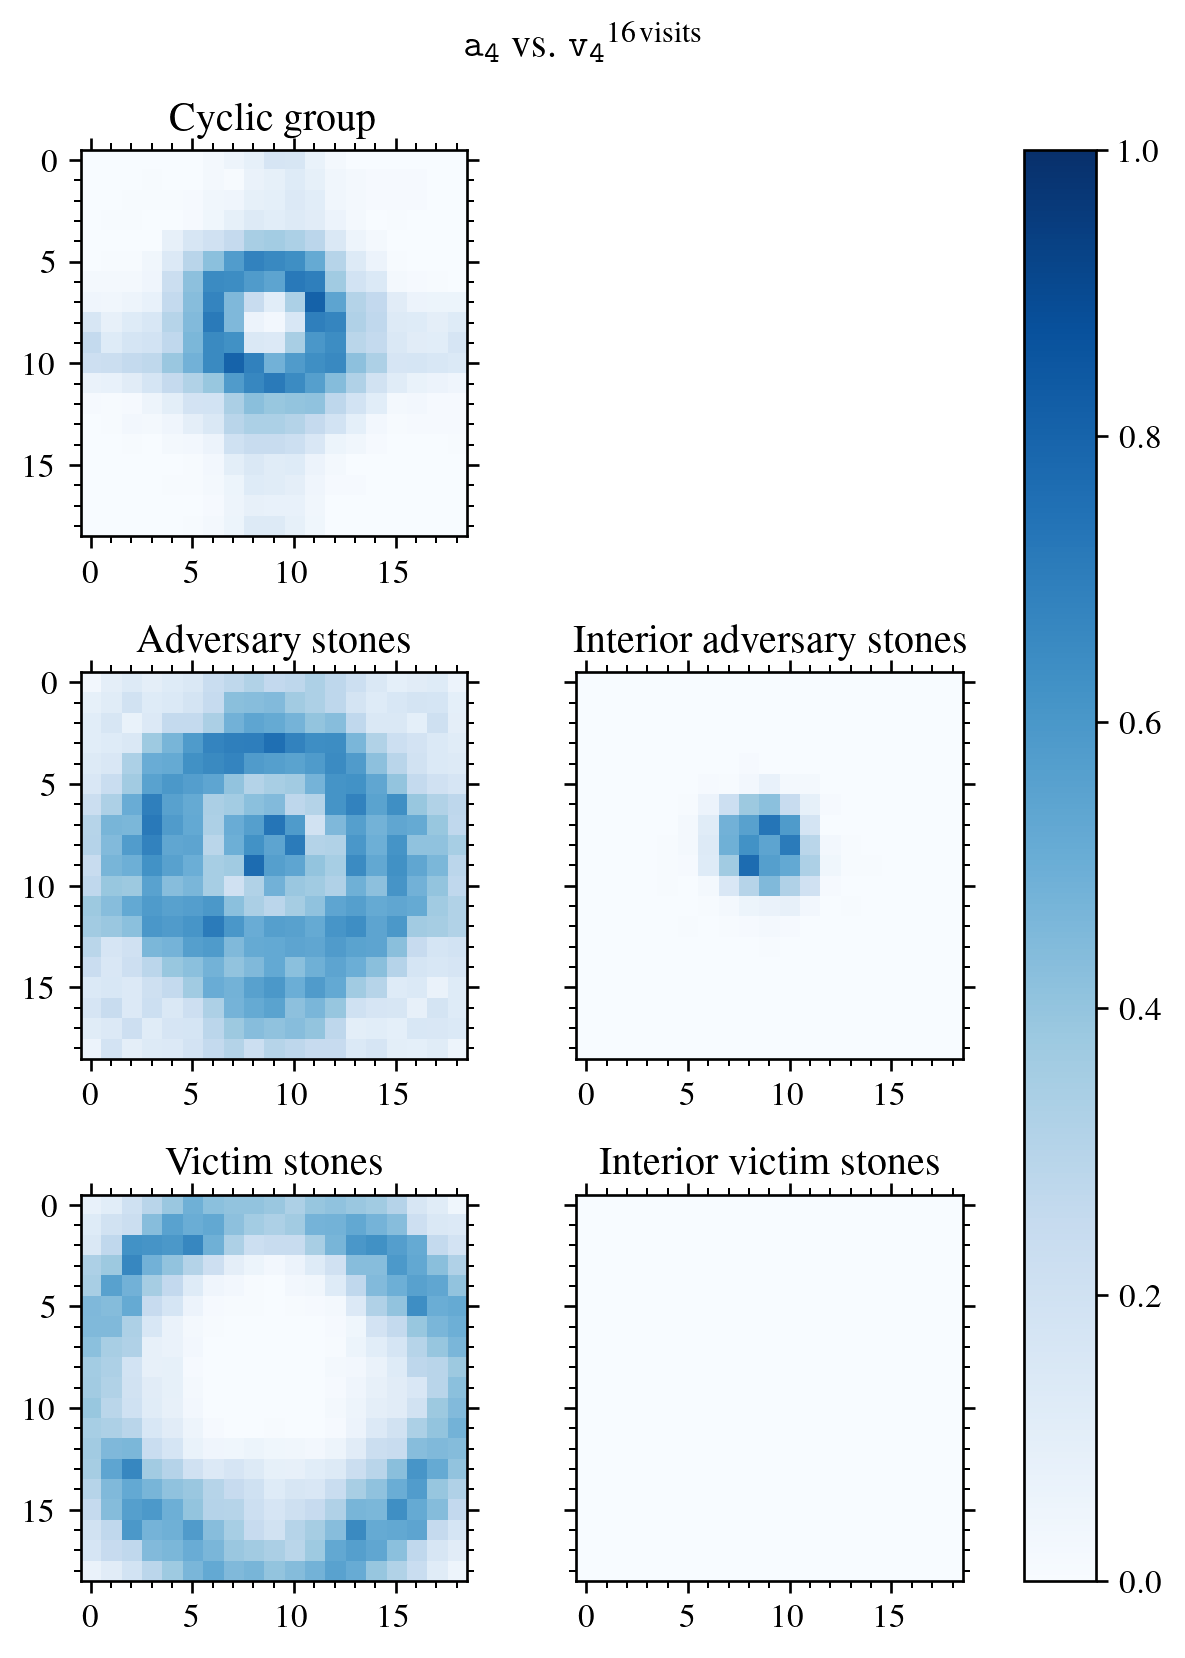

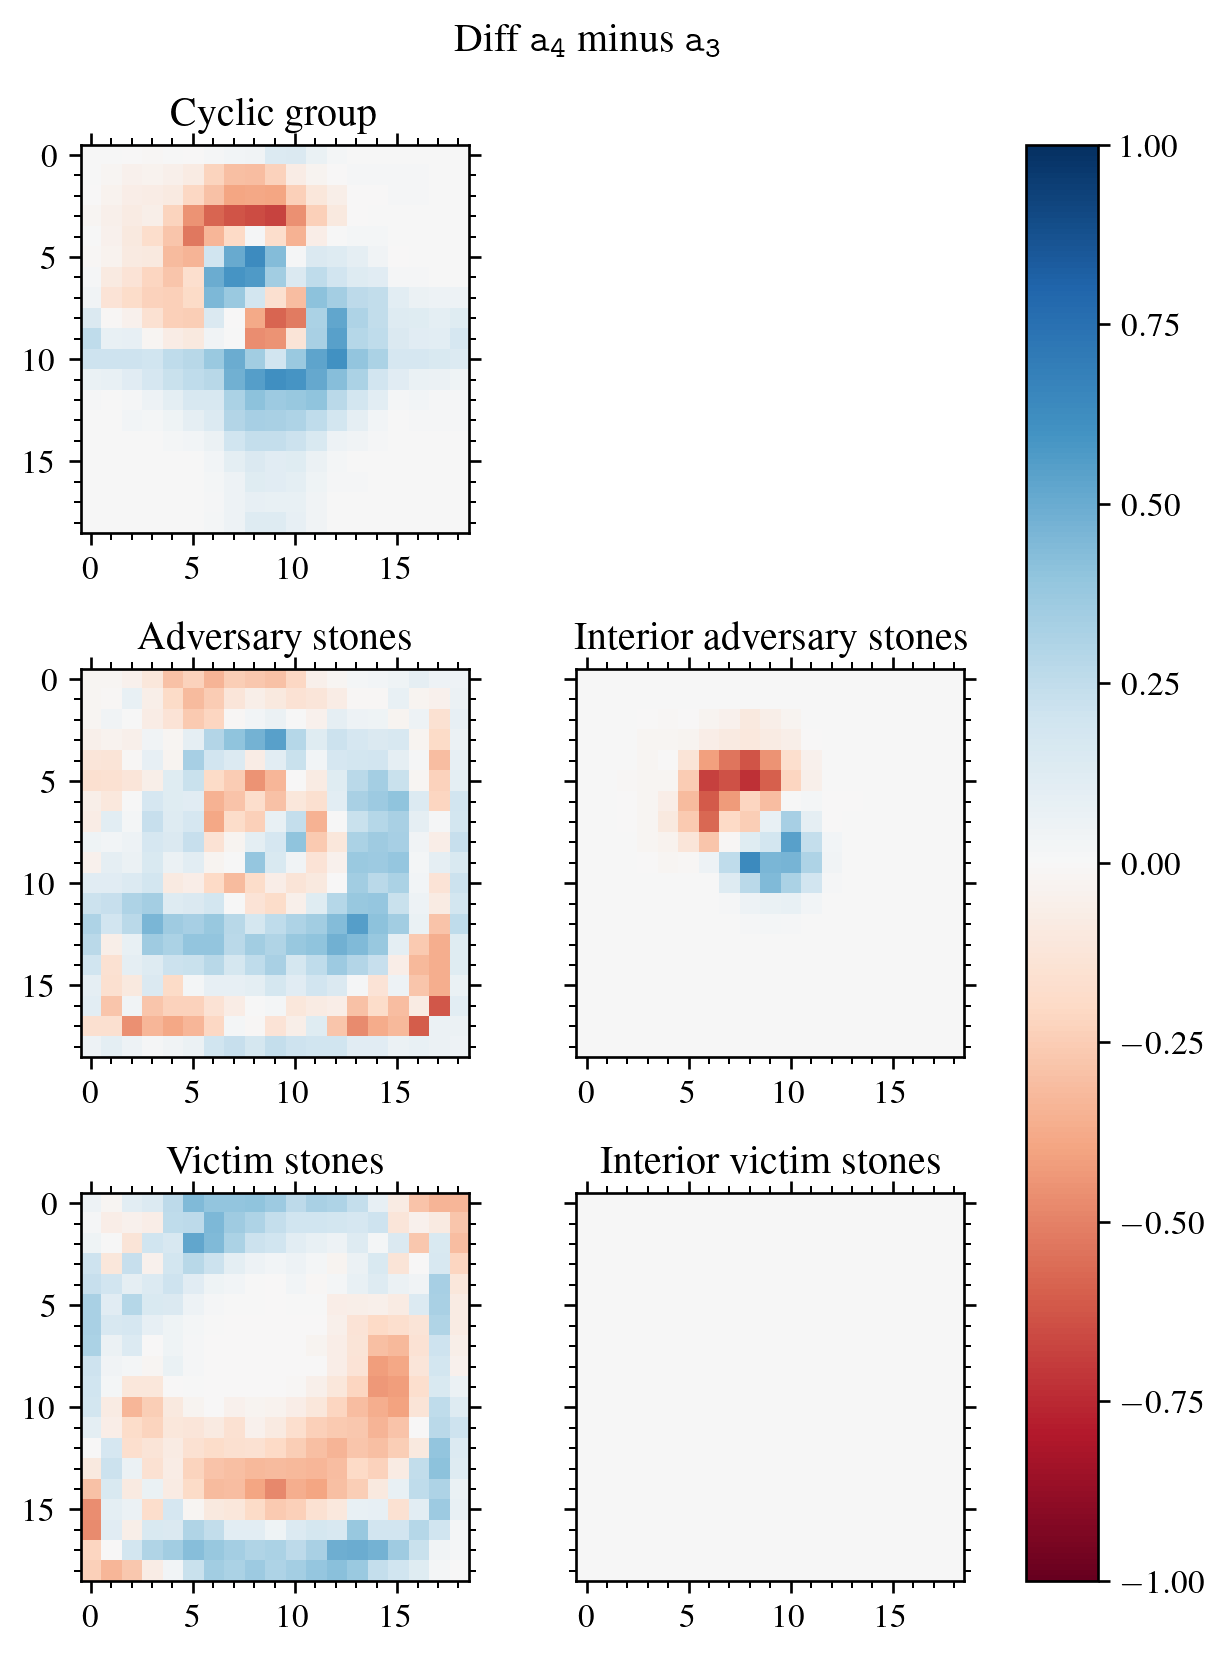

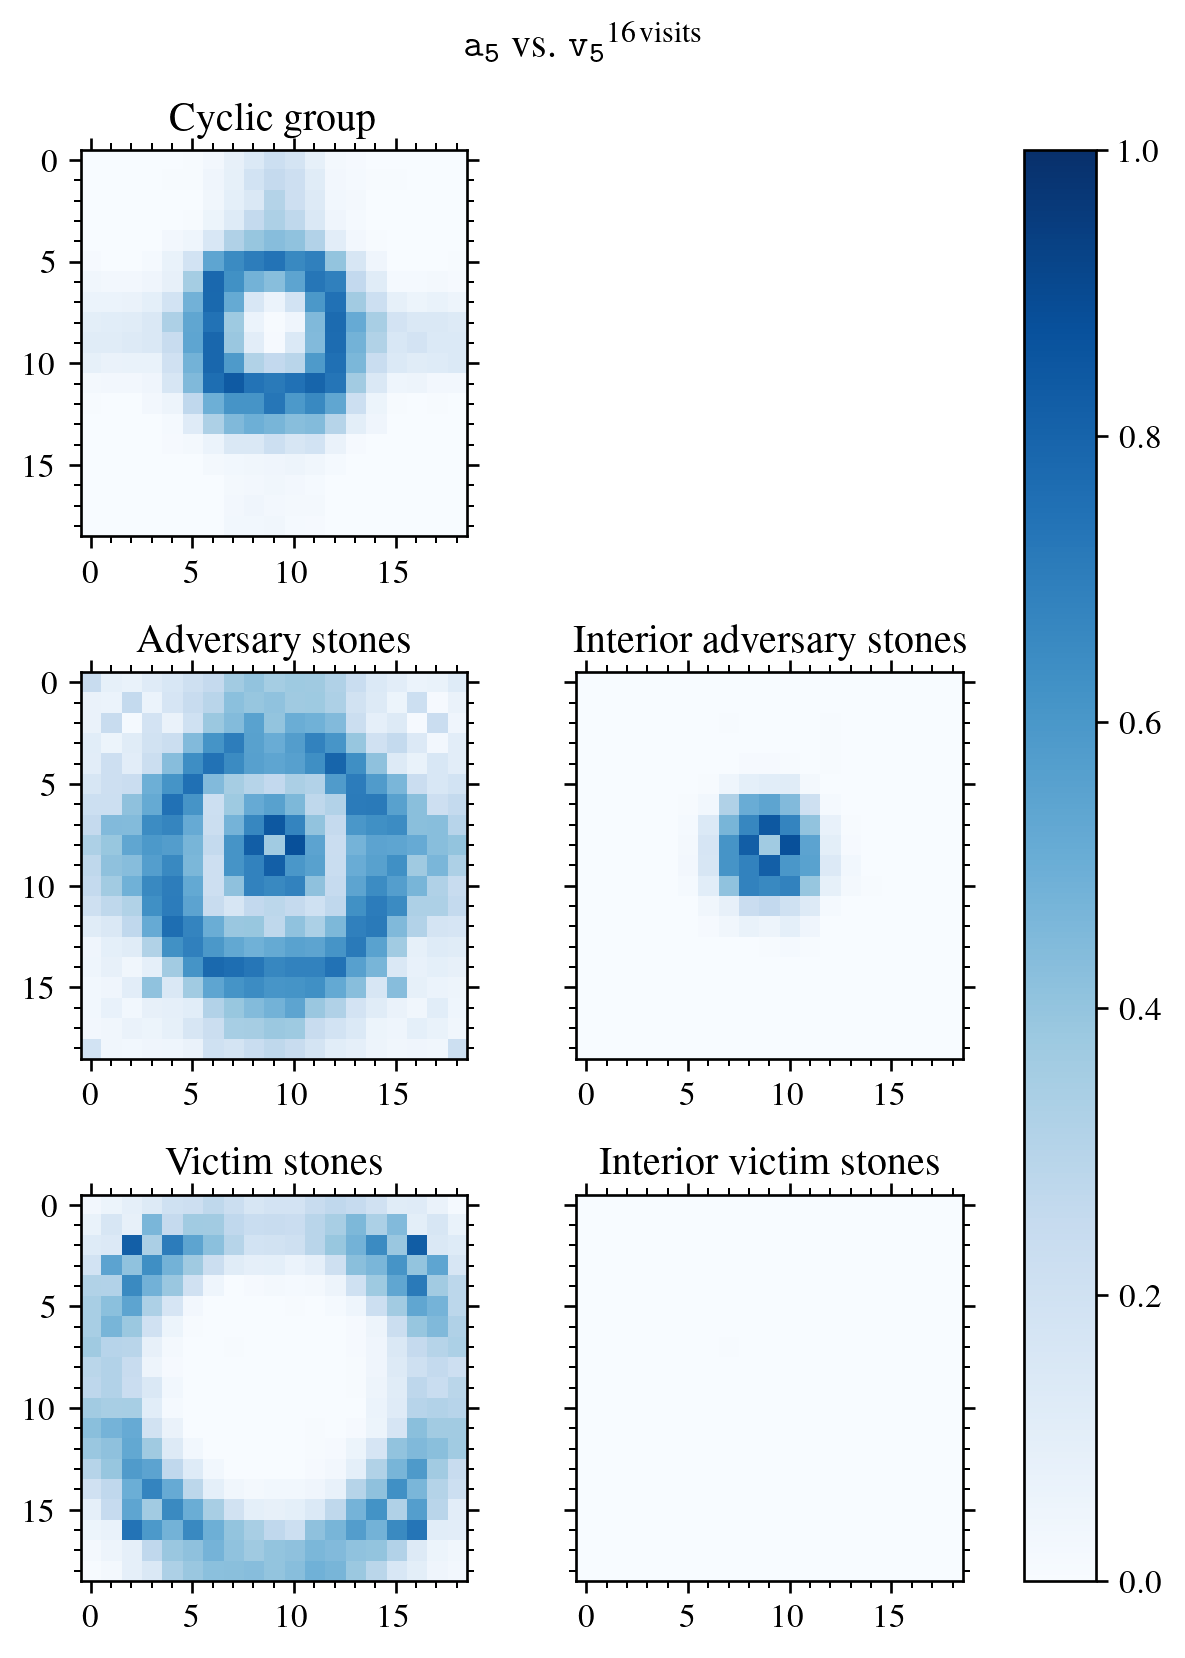

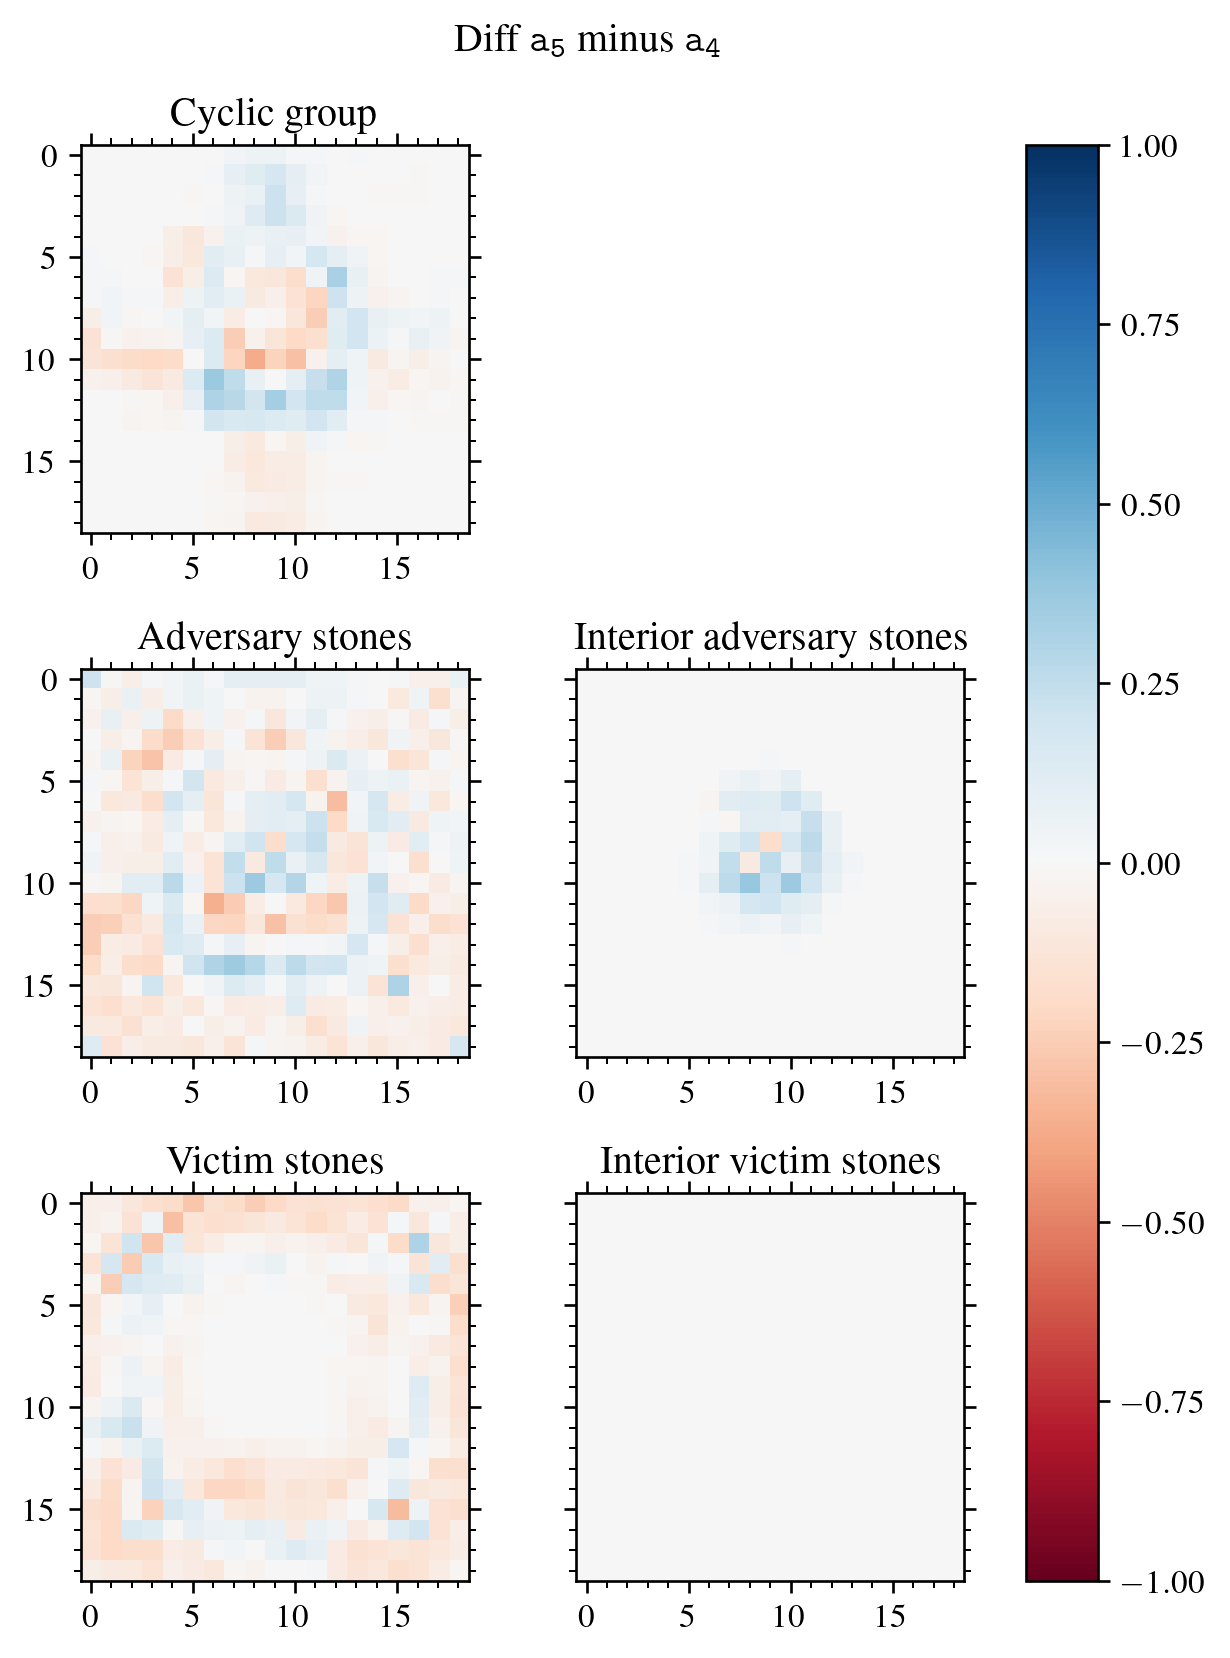

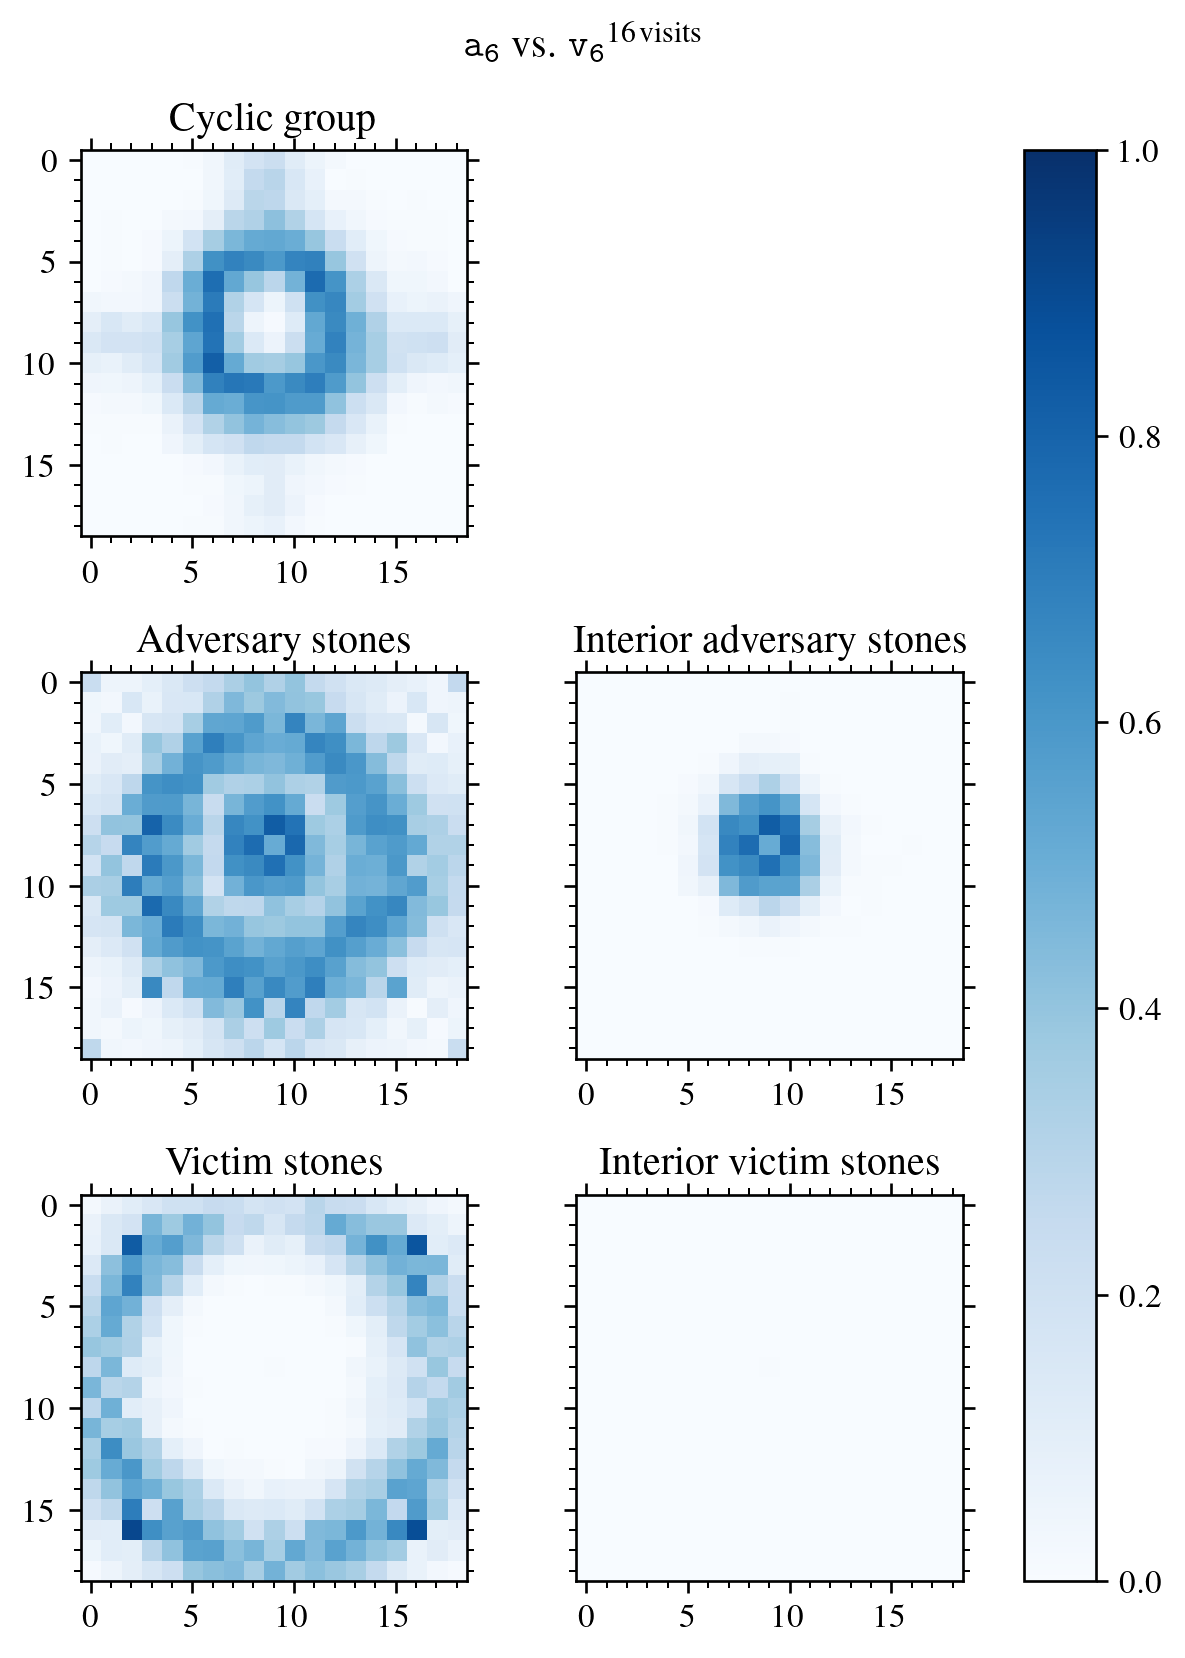

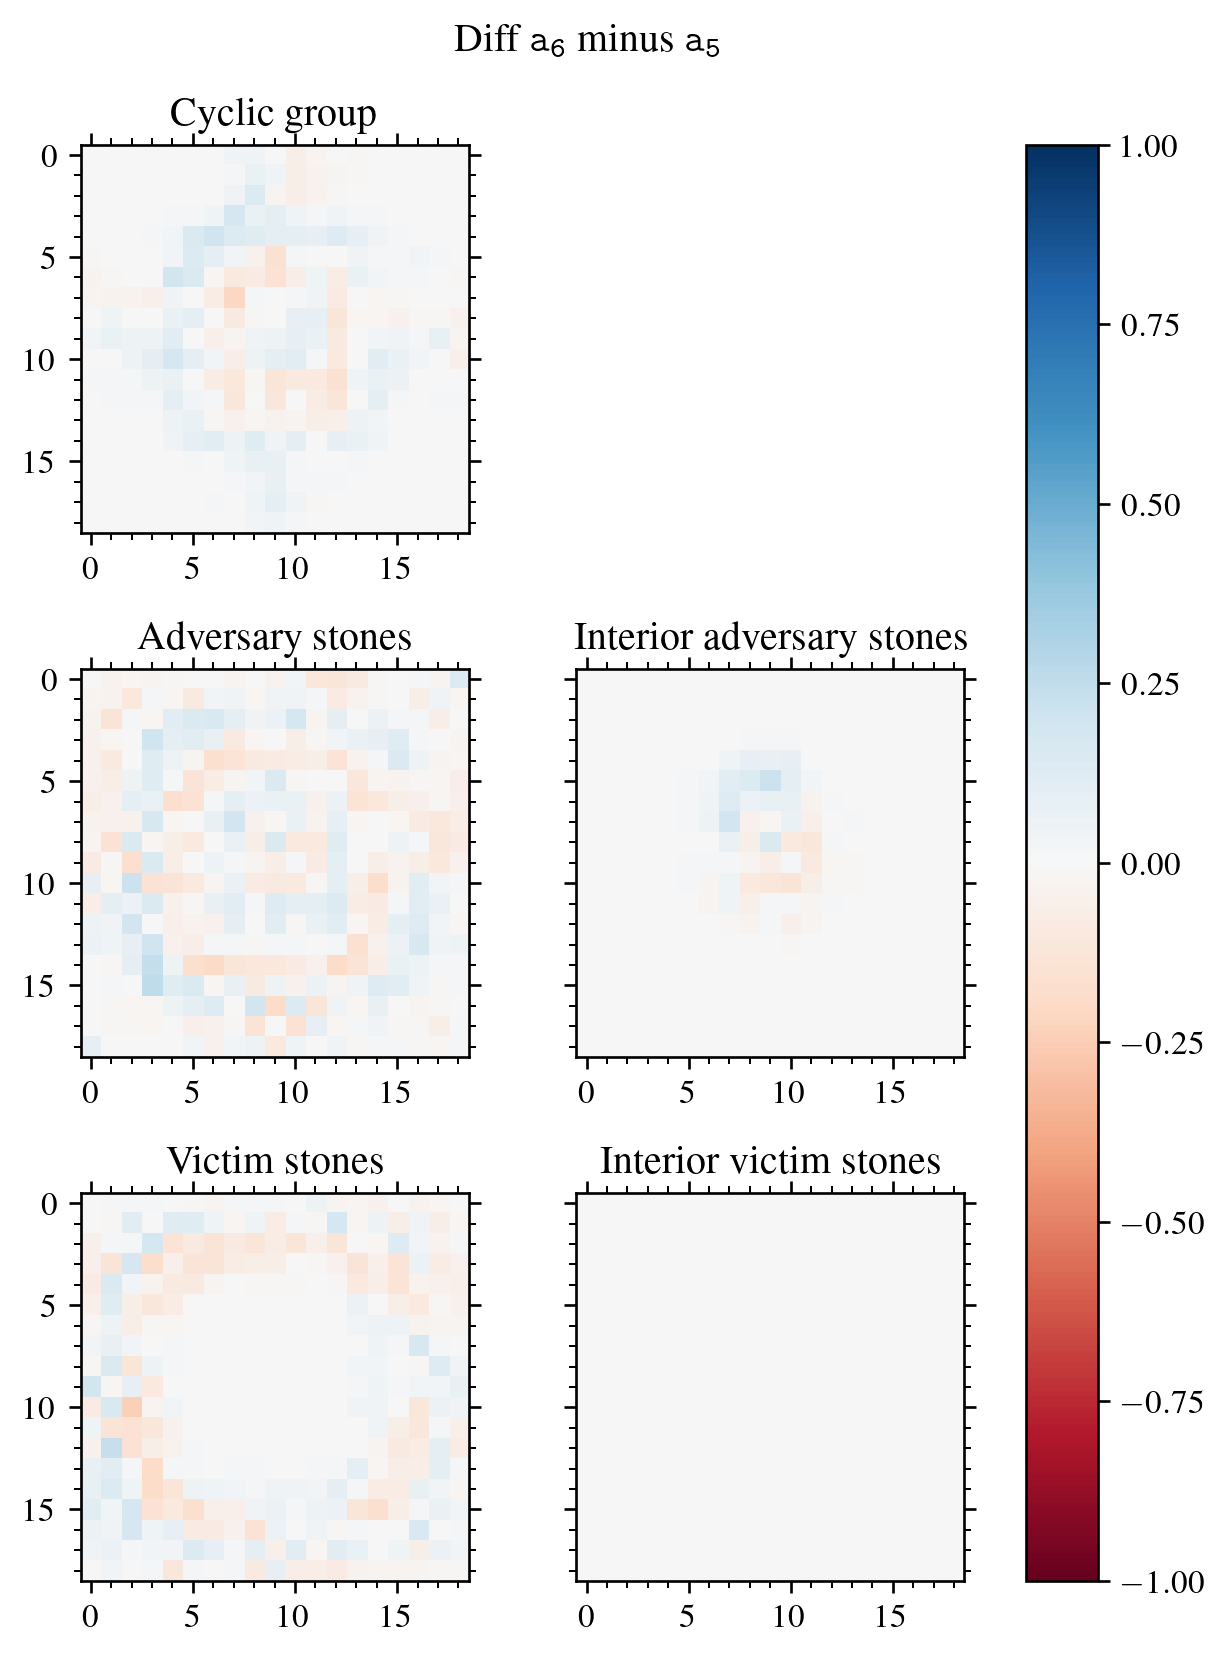

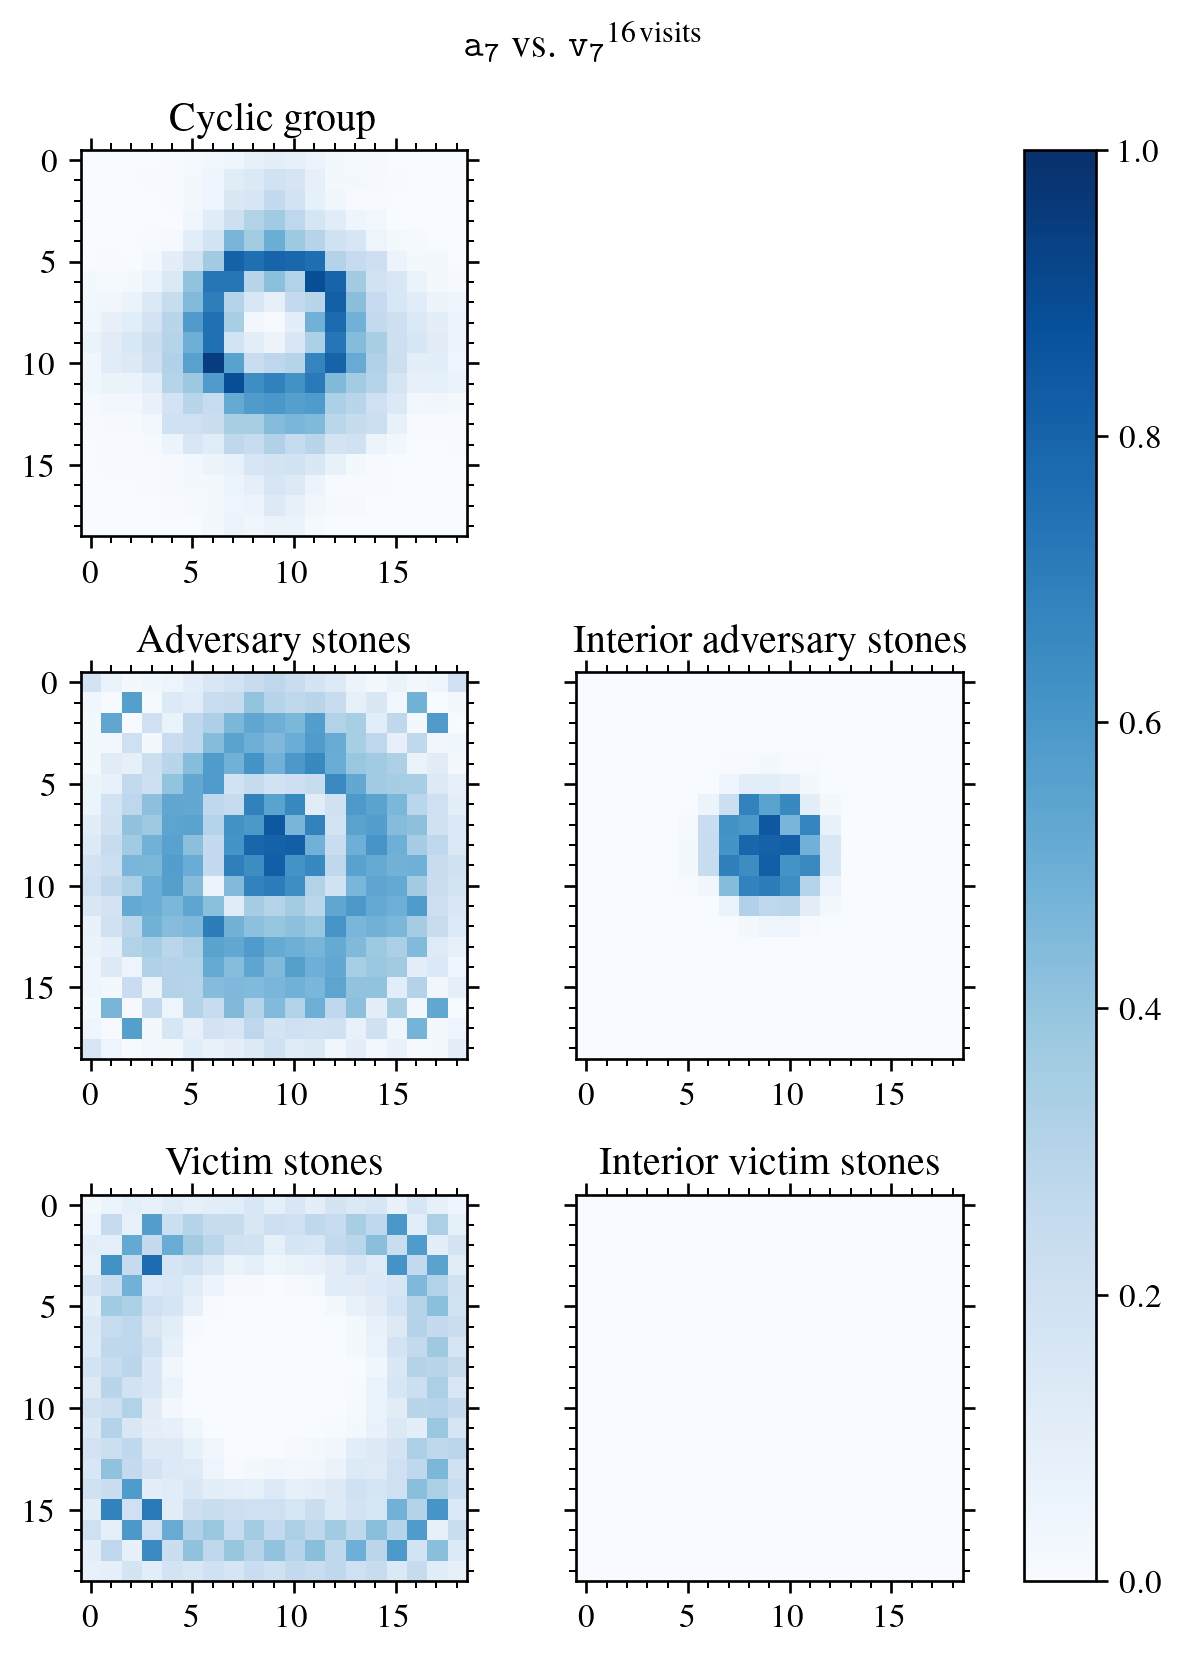

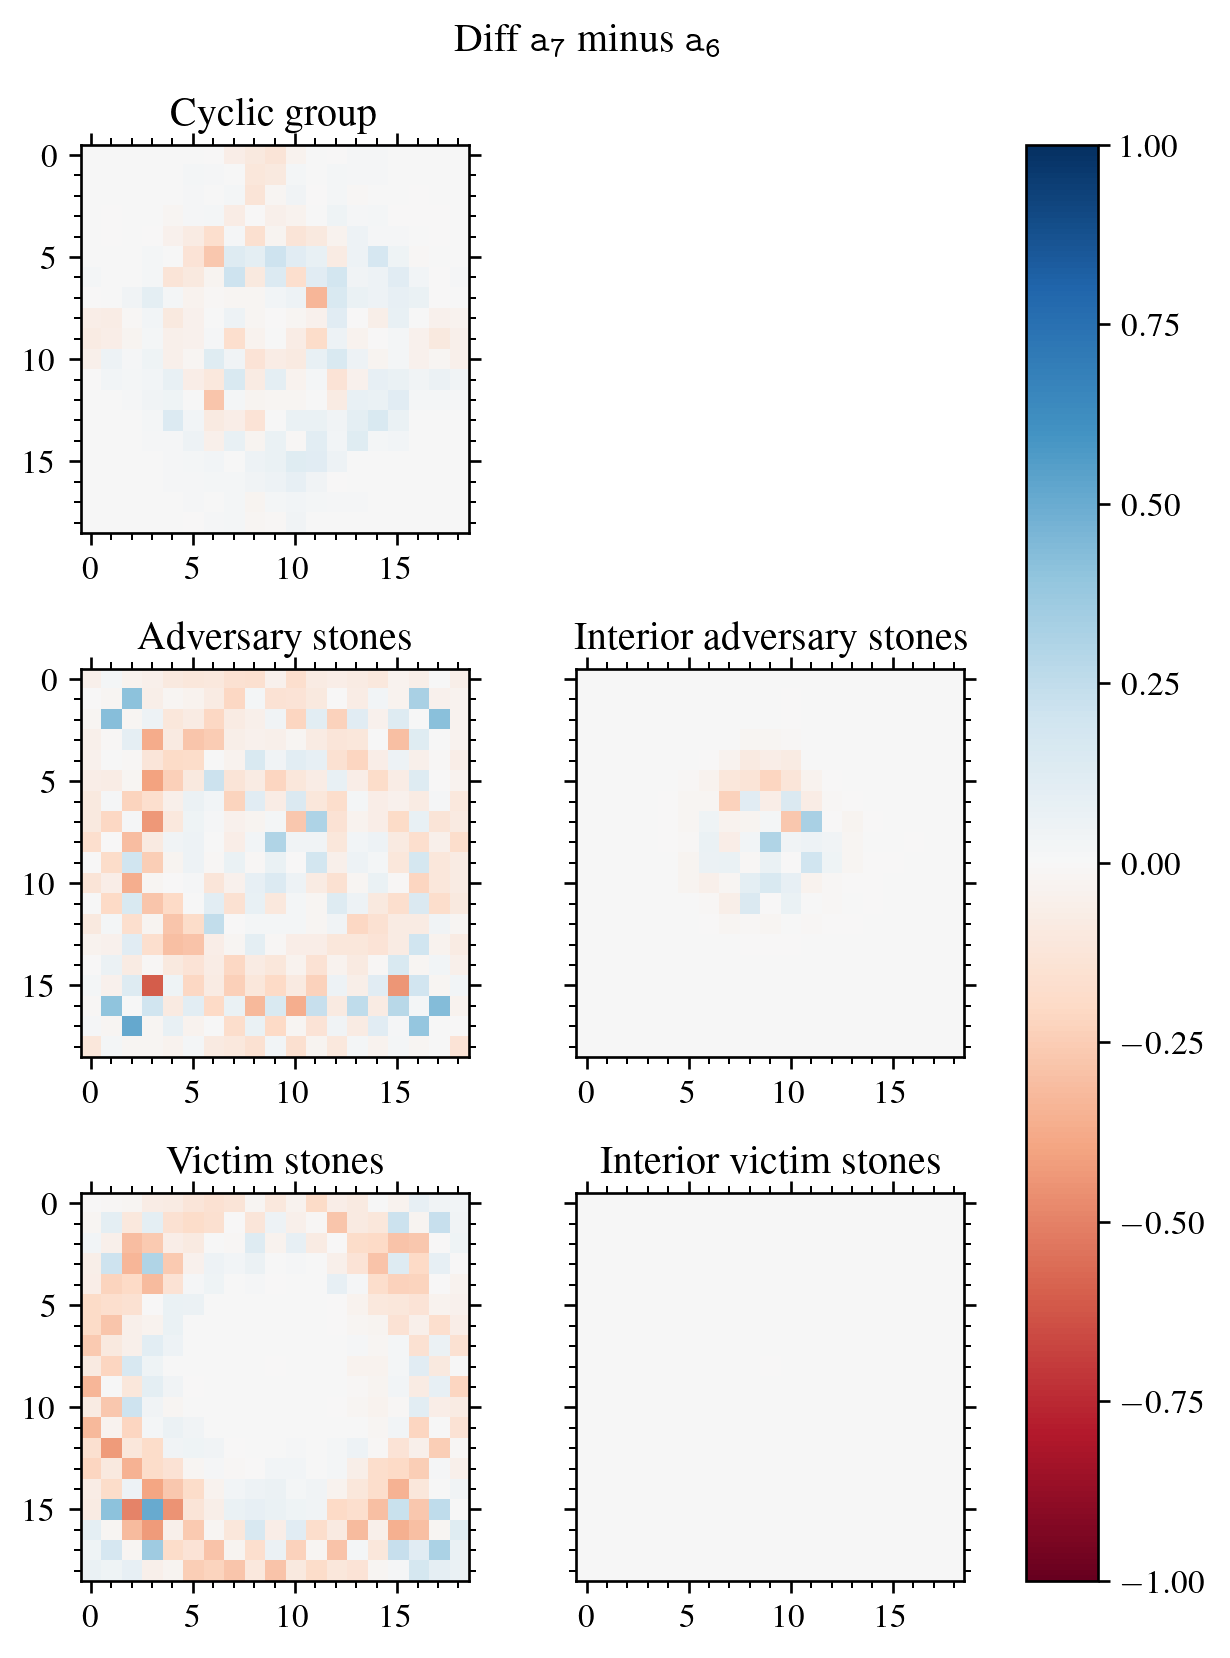

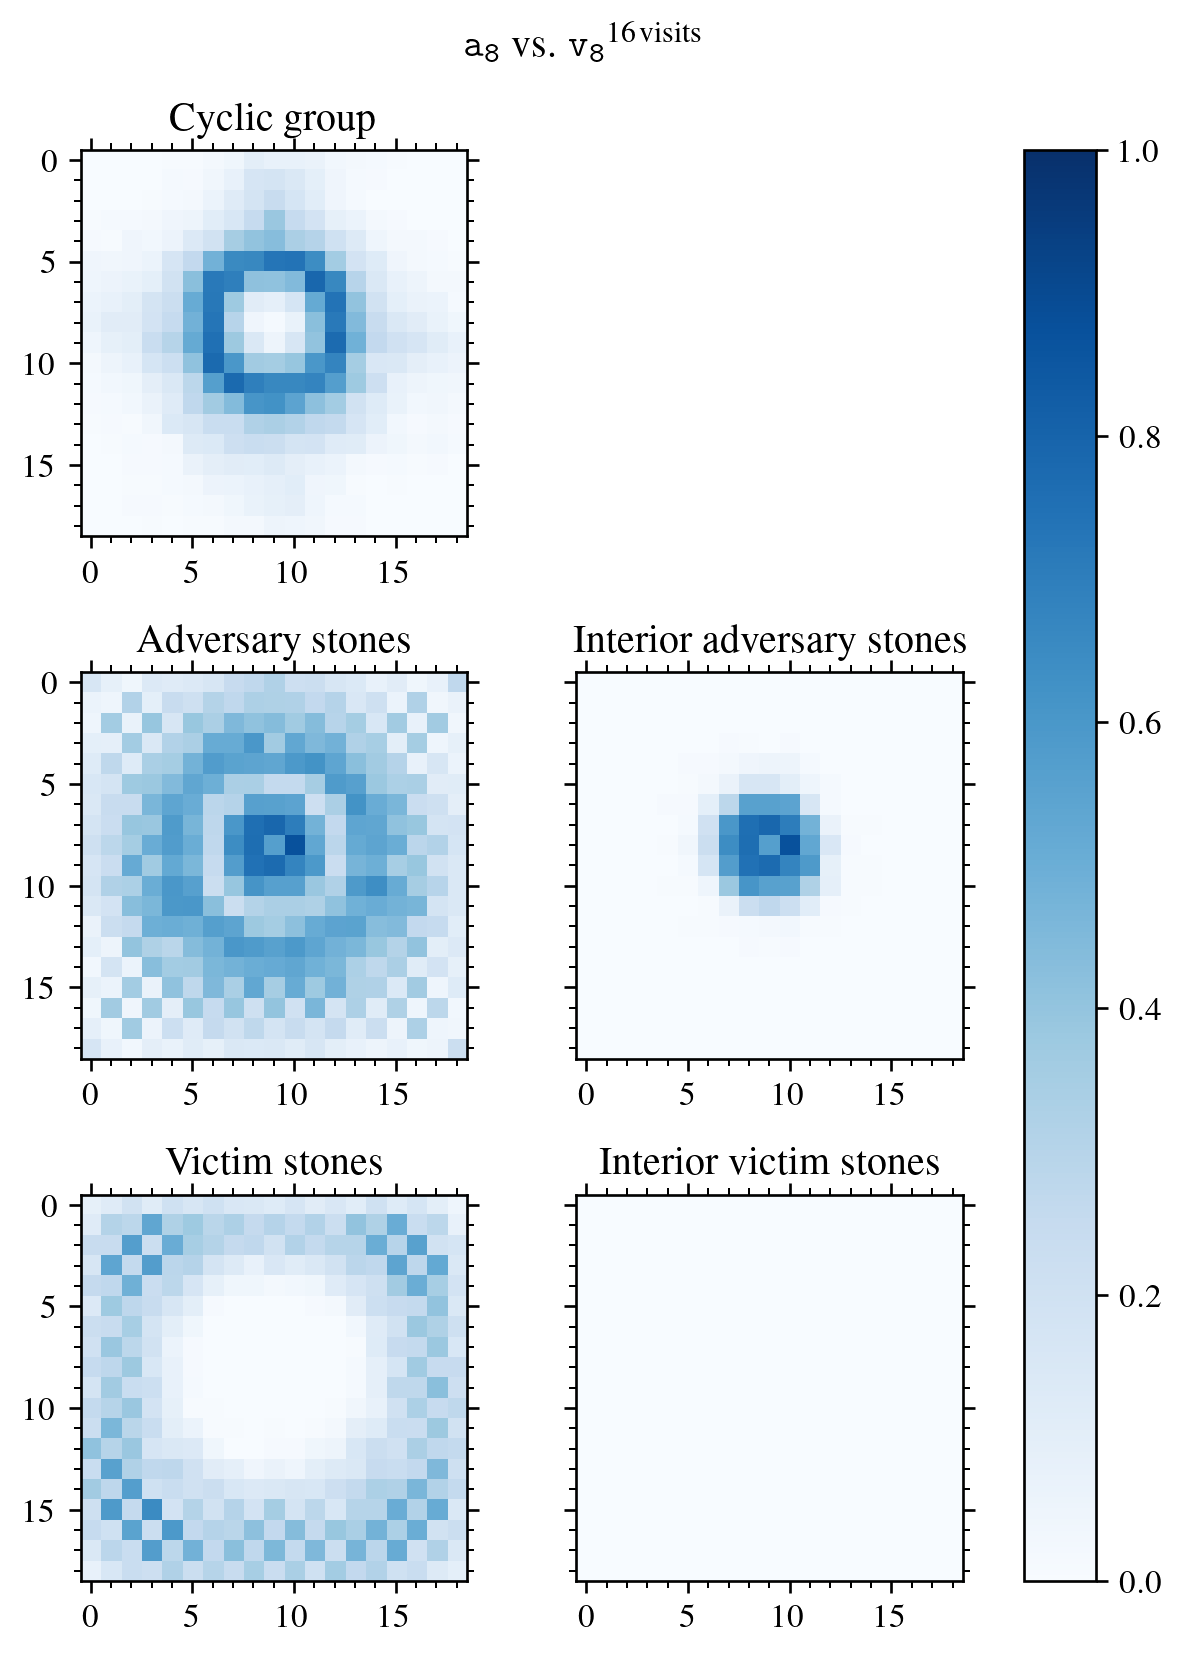

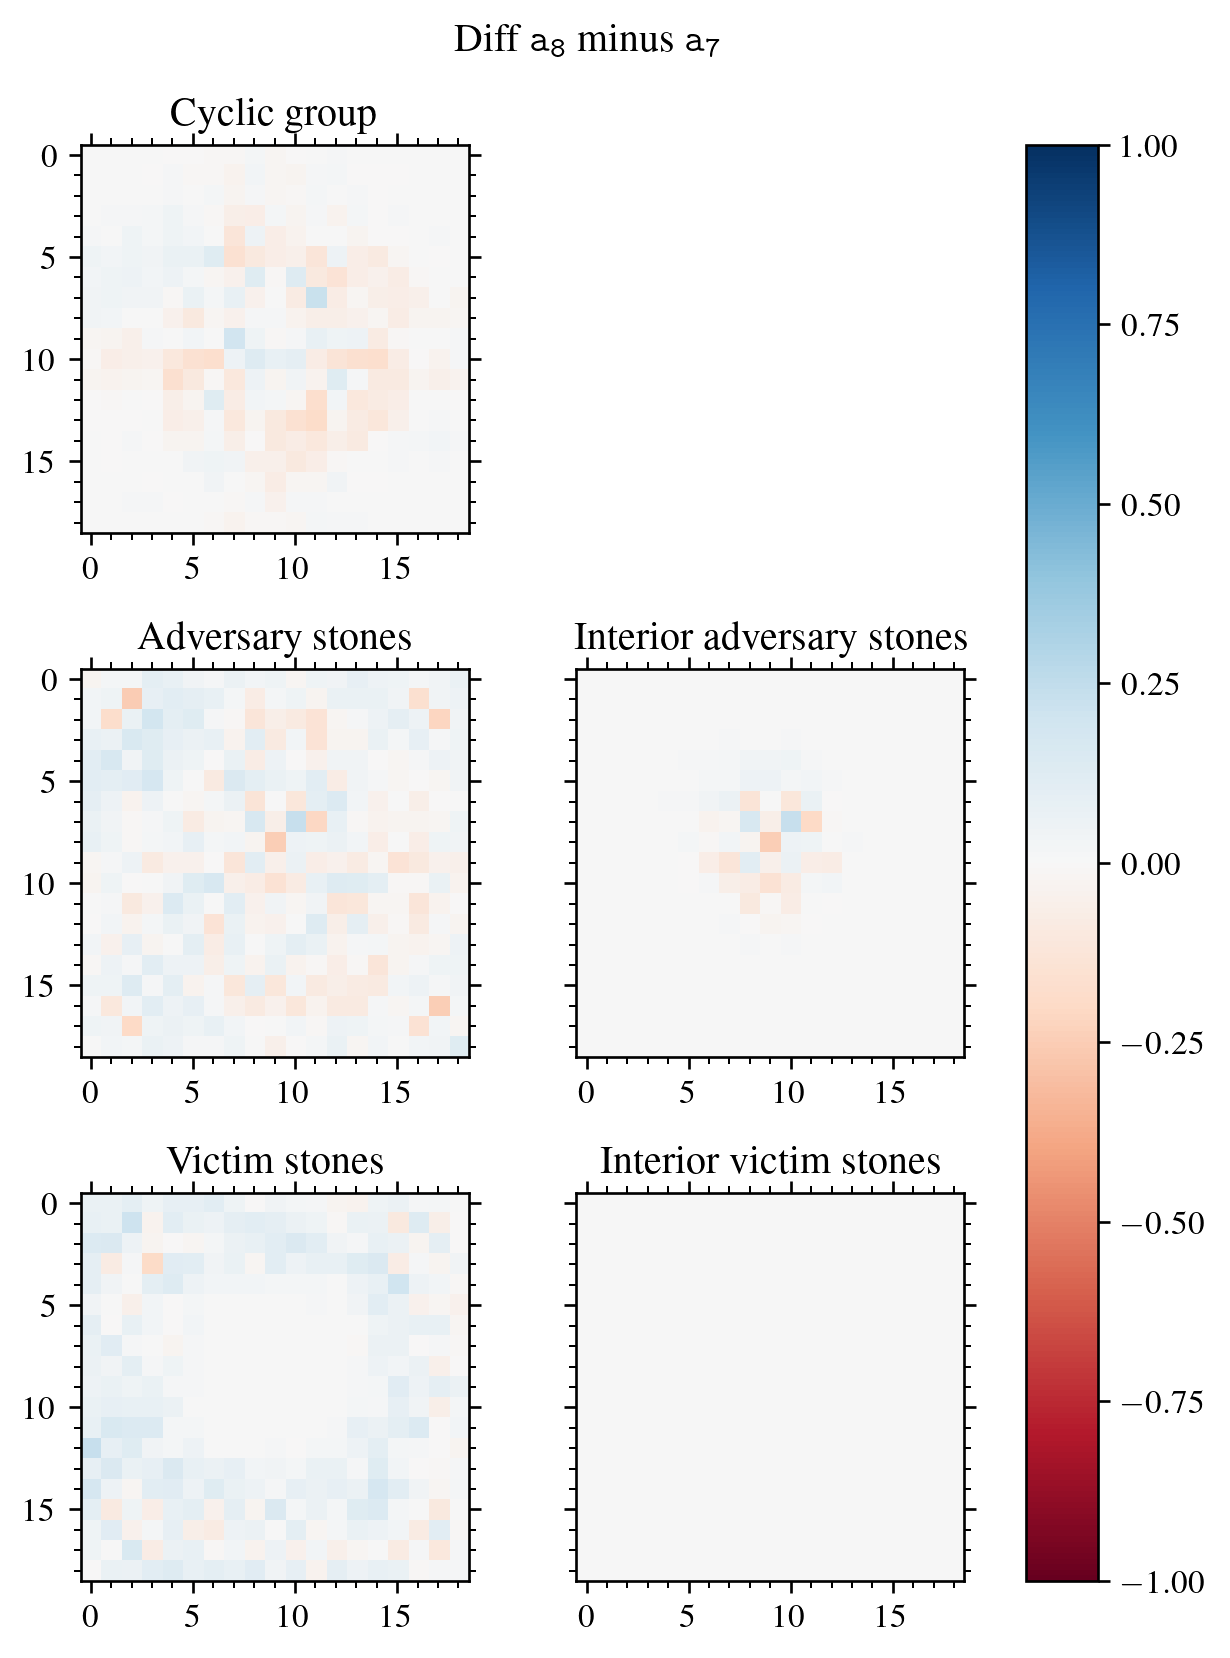

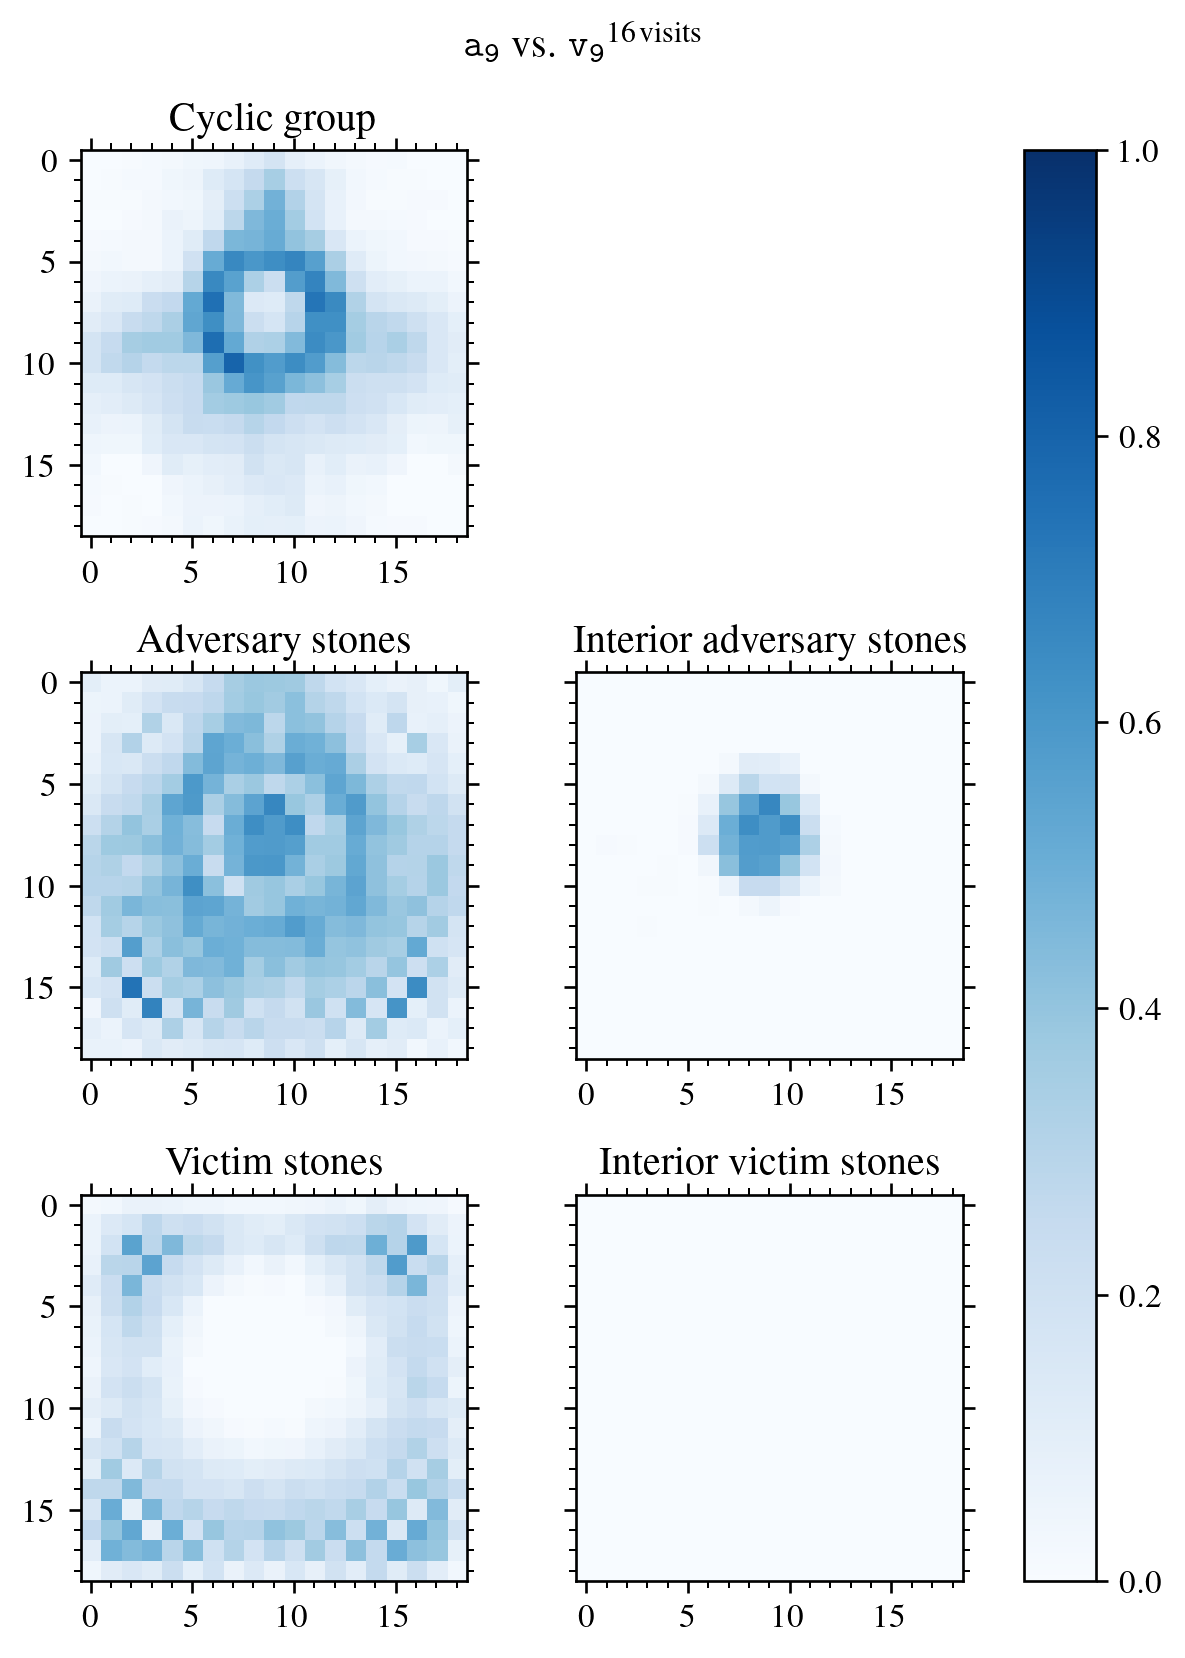

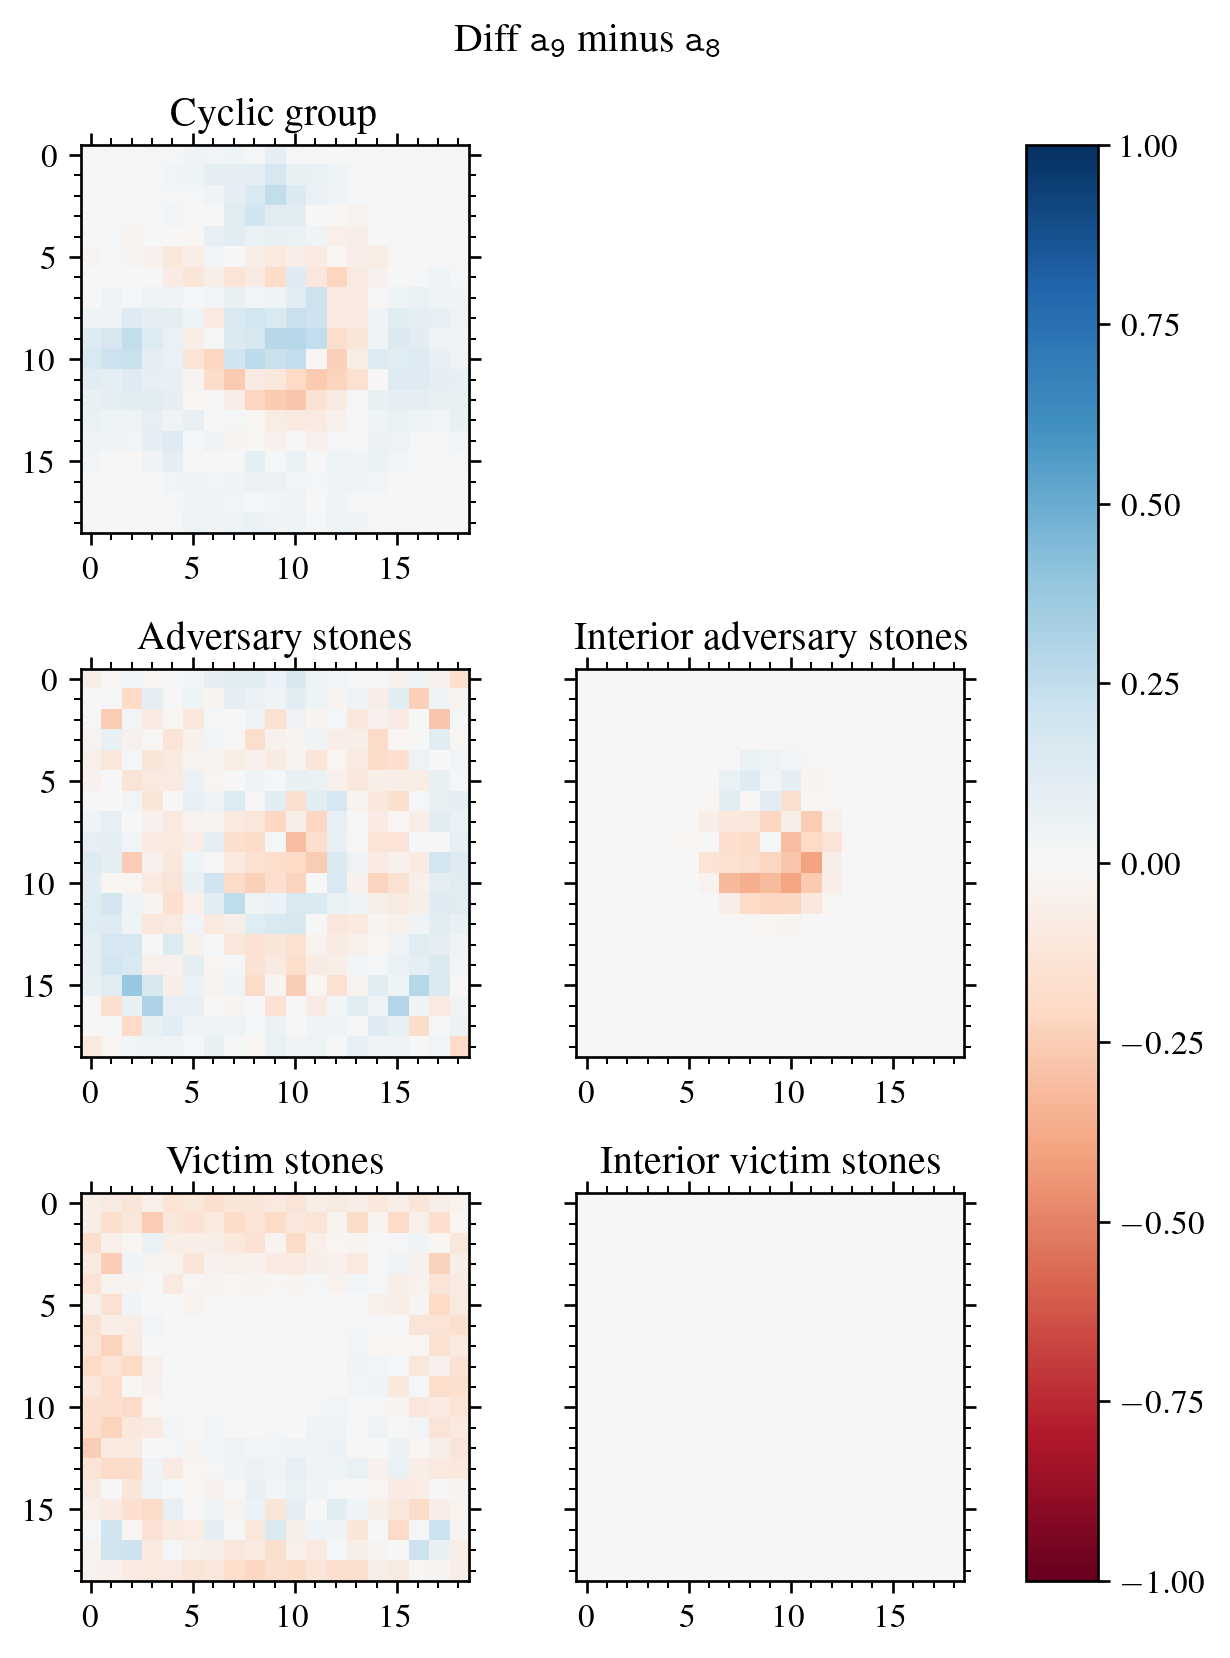

In [6]:
for i in range(10):
    main(
        files=[GAMES_DIR / "rs-vs-hs-v16" / f"{i}.sgfs"],
        title=rf"\attackiter{{{i}}} vs. $\defenseiter{{{i}}}^\mathrm{{16\,visits}}$",
        output_path=f"cyclic-heatmap-r{i}.pgf",
    )
    if i == 0:
        continue
    main(
        files=[GAMES_DIR / "rs-vs-hs-v16" / f"{i}.sgfs"],
        title=rf"Diff \attackiter{{{i}}} minus \attackiter{{{i - 1}}}",
        output_path=f"cyclic-heatmap-diff-r{i}.pgf",
        diff_files=[GAMES_DIR / "rs-vs-hs-v16" / f"{i - 1}.sgfs"],
    )